In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install deap

In [3]:
!pip install bitstring

In [4]:
!pip install transforms3d

In [5]:
!pip install tsaug

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from scipy import stats 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

In [7]:
pwd

'/content'

In [8]:
%cd "/content/drive/My Drive/Colab Notebooks/covid-dataset/"

/content/drive/My Drive/Colab Notebooks/covid-dataset


In [9]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [10]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/covid-dataset/owid-covid-data.csv') # having First.csv zipped file.

In [11]:
#%%time 
#!wget -O owid-covid-data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv

In [12]:
# Les 5 premères lignes du dataset 
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [13]:
df[df.continent  == 'Africa'].shape
# soit 54 pays en afrique ,3 mois de COVID = approximativement 4800

(8414, 36)

In [14]:
#Taille des données de COVID pour le Maroc
df[df.location  == 'Morocco'].shape

(191, 36)

In [15]:
#Première date d'enregistrement de cas dans le monde 
df.date.min()

'2019-12-31'

In [16]:
# dernière date d'enregistrement pour notre datset
df.date.max()

'2020-08-15'

In [17]:
# Première date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.min()

'2020-02-07'

In [18]:
# dernière date d'enregistrement de cas au Maroc 
df[(df.location  == 'Morocco')].date.max()

'2020-08-15'

In [19]:
df.date= pd.to_datetime(df['date'],format='%Y-%m-%d')

In [20]:
df=df[['new_cases','total_cases','total_deaths','new_deaths', 'population','date','location']]


In [21]:
df = df.fillna(df.median())

In [22]:
df[(df.location  == 'Morocco')].tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23085,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
23086,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
23087,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
23088,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
23089,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco
23090,826.0,34063.0,516.0,18.0,36910558.0,2020-08-11,Morocco
23091,1132.0,35195.0,533.0,17.0,36910558.0,2020-08-12,Morocco
23092,1499.0,36694.0,556.0,23.0,36910558.0,2020-08-13,Morocco
23093,1241.0,37935.0,584.0,28.0,36910558.0,2020-08-14,Morocco
23094,1306.0,39241.0,611.0,27.0,36910558.0,2020-08-15,Morocco


In [23]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    myNoise =  np.add(myNoise,abs(np.min(myNoise)))
    return X+myNoise

In [24]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    scalingFactor = np.add(scalingFactor,abs(np.min(scalingFactor)))
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

In [25]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

In [26]:
#df['month'] = df['date'].dt.month

In [27]:
nb_seq=1
n_out=7
nb_col=5

In [28]:
start_date = '2020-06-15'
end_date = '2020-08-01'
start_date2 = '2020-08-02'
end_date2 = '2020-08-15'

In [29]:
#mask = (covid_data['date'] >= start_date) & (covid_data['date'] <= end_date) &  (covid_data['location'].isin(['Morocco']))
mask1 = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))

In [30]:
mask2 = (df['date'] >= start_date2) & (df['date'] <= end_date2) &  (df['location'].isin(['Morocco']))

In [31]:
df.sort_values(by=['location'], inplace=True)


In [32]:
X_train = df.loc[mask1].sort_index(axis = 0) 
X_train.shape

(48, 7)

In [33]:
X_train.head(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco


In [34]:
X_train.tail(5)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [35]:
#Date to add test set 
data_add_test = X_train[X_train.location =='Morocco'].tail(nb_seq)

In [36]:
'''
# AUGMENTATION 

start_date = '2020-06-25'
end_date = '2020-07-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
X_1 = df.loc[mask].sort_index(axis = 0) 
X_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1

X_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)
X_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']
X_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)
X_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']

X_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)
X_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']
X_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)
X_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']

X_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)
X_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']
X_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)
X_4[['total_deaths']] = X_4['total_deaths'] + X_4['new_deaths']

X_5[['new_cases']] = DA_Jitter(X_5[['new_cases']], sigma=1000)
X_5[['total_cases']] = X_5['total_cases'] + X_5['new_cases']
X_5[['new_deaths']] = DA_Jitter(X_5[['new_deaths']], sigma=40)
X_5[['total_deaths']] = X_5['total_deaths'] + X_5['new_deaths']

X_6[['new_cases']] = DA_Jitter(X_6[['new_cases']], sigma=1000)
X_6[['total_cases']] = X_6['total_cases'] + X_6['new_cases']
X_6[['new_deaths']] = DA_Jitter(X_6[['new_deaths']], sigma=50)
X_6[['total_deaths']] = X_6['total_deaths'] + X_6['new_deaths']


#X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_6[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=2000)
#X_8[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']] = DA_Scaling(X_7[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']], sigma=3000)
#X_4 = pd.DataFrame(X_4,columns=cols_need)
#print(X_1.shape)
X_train = pd.concat([X_train, X_2,X_3,X_4,X_5,X_6], ignore_index=True)
'''

"\n# AUGMENTATION \n\nstart_date = '2020-06-25'\nend_date = '2020-07-31'\nmask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))\nX_1 = df.loc[mask].sort_index(axis = 0) \nX_2 = X_3 = X_4 =X_5=X_6=X_7=X_8= X_1\n\nX_2[['new_cases']] = DA_Jitter(X_2[['new_cases']], sigma=1000)\nX_2[['total_cases']] = X_2['total_cases'] + X_2['new_cases']\nX_2[['new_deaths']] = DA_Jitter(X_2[['new_deaths']], sigma=10)\nX_2[['total_deaths']] = X_2['total_deaths'] + X_2['new_deaths']\n\nX_3[['new_cases']] = DA_Jitter(X_3[['new_cases']], sigma=500)\nX_3[['total_cases']] = X_3['total_cases'] + X_3['new_cases']\nX_3[['new_deaths']] = DA_Jitter(X_3['new_deaths'], sigma=20)\nX_3[['total_deaths']] = X_3['total_deaths'] + X_3['new_deaths']\n\nX_4[['new_cases']] = DA_Jitter(X_4[['new_cases']], sigma=1000)\nX_4[['total_cases']] = X_4['total_cases'] + X_4['new_cases']\nX_4[['new_deaths']] = DA_Jitter(X_4[['new_deaths']], sigma=30)\nX_4[['total_deaths']] = X_4['total_deaths'

In [37]:
X_train.shape

(48, 7)

In [38]:
X_train.head(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23033,42.0,8734.0,212.0,0.0,36910558.0,2020-06-15,Morocco
23034,104.0,8838.0,212.0,0.0,36910558.0,2020-06-16,Morocco
23035,83.0,8921.0,212.0,0.0,36910558.0,2020-06-17,Morocco
23036,76.0,8997.0,213.0,1.0,36910558.0,2020-06-18,Morocco
23037,77.0,9074.0,213.0,0.0,36910558.0,2020-06-19,Morocco
23038,539.0,9613.0,213.0,0.0,36910558.0,2020-06-20,Morocco
23039,188.0,9801.0,213.0,0.0,36910558.0,2020-06-21,Morocco
23040,176.0,9977.0,214.0,1.0,36910558.0,2020-06-22,Morocco
23041,195.0,10172.0,214.0,0.0,36910558.0,2020-06-23,Morocco
23042,92.0,10264.0,214.0,0.0,36910558.0,2020-06-24,Morocco


In [39]:
X_train.tail(10)

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
23071,220.0,17962.0,285.0,5.0,36910558.0,2020-07-23,Morocco
23072,302.0,18264.0,292.0,7.0,36910558.0,2020-07-24,Morocco
23073,570.0,18834.0,299.0,7.0,36910558.0,2020-07-25,Morocco
23074,811.0,19645.0,305.0,6.0,36910558.0,2020-07-26,Morocco
23075,633.0,20278.0,313.0,8.0,36910558.0,2020-07-27,Morocco
23076,609.0,20887.0,316.0,3.0,36910558.0,2020-07-28,Morocco
23077,500.0,21387.0,327.0,11.0,36910558.0,2020-07-29,Morocco
23078,826.0,22213.0,334.0,7.0,36910558.0,2020-07-30,Morocco
23079,1046.0,23259.0,346.0,12.0,36910558.0,2020-07-31,Morocco
23080,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco


In [40]:
X_test = df.loc[mask2].sort_index(axis = 0) 

X_test.shape

(14, 7)

In [41]:
X_test = pd.concat([pd.DataFrame(data_add_test),X_test], ignore_index=True)
X_test = X_test.sort_index(axis = 0)

In [42]:
X_test

,new_cases,total_cases,total_deaths,new_deaths,population,date,location
0,1063.0,24322.0,353.0,7.0,36910558.0,2020-08-01,Morocco
1,693.0,25015.0,367.0,14.0,36910558.0,2020-08-02,Morocco
2,522.0,25537.0,382.0,15.0,36910558.0,2020-08-03,Morocco
3,659.0,26196.0,401.0,19.0,36910558.0,2020-08-04,Morocco
4,1021.0,27217.0,417.0,16.0,36910558.0,2020-08-05,Morocco
5,1283.0,28500.0,435.0,18.0,36910558.0,2020-08-06,Morocco
6,1144.0,29644.0,449.0,14.0,36910558.0,2020-08-07,Morocco
7,1018.0,30662.0,461.0,12.0,36910558.0,2020-08-08,Morocco
8,1345.0,32007.0,480.0,19.0,36910558.0,2020-08-09,Morocco
9,1230.0,33237.0,498.0,18.0,36910558.0,2020-08-10,Morocco


In [43]:
X_test['timestamp'] = pd.to_datetime(X_test['date'], infer_datetime_format=True)
X_test.set_index('timestamp', inplace=True)

X_train['timestamp'] = pd.to_datetime(X_train['date'], infer_datetime_format=True)
X_train.set_index('timestamp', inplace=True)

In [44]:
X_train=X_train[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]

X_test=X_test[['new_cases','total_cases','total_deaths', 'new_deaths', 'population']]
Y_test=X_test[['new_cases']]

Y_train=X_train[['new_cases']]

In [45]:
days=X_test[nb_seq:].index
days=days.sort_values()

In [46]:
#days=days[nb_seq:]

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(48, 5)
(48, 1)
(15, 5)
(15, 1)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler2= MinMaxScaler(feature_range=(0, 1))

In [49]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [50]:

X_train=X_train
X_test=X_test
Y_train=Y_train
Y_test=Y_test

# ensure all data is float
X_train = X_train.astype('float32')
# ensure all data is float
X_test = X_test.astype('float32')
# ensure all data is float
Y_test = Y_test.astype('float32')
# ensure all data is float
Y_train = Y_train.astype('float32')

# normalize features

X_train= scaler.fit_transform(X_train)
X_test= scaler.fit_transform(X_test)
Y_train= scaler2.fit_transform(Y_train)
Y_test= scaler2.fit_transform(Y_test)

# reframe as supervised learning
# on doit toujours vers une conversion vers n_out ensuite con choisit le nombre de colonnes dont nous avons besoins
X_train = series_to_supervised(X_train, nb_seq, n_out)
X_test = series_to_supervised(X_test, nb_seq, n_out)
print(X_train)
print(X_train.shape)
print(X_test.shape)
Y_train = series_to_supervised(Y_train, nb_seq, n_out)
Y_test = series_to_supervised(Y_test, nb_seq, n_out)
print(Y_train.shape)
print(Y_test.shape)


    var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t+6)  var4(t+6)  var5(t+6)
1    0.039511   0.000000   0.000000  ...   0.014184   0.083333        0.0
2    0.097836   0.006672   0.000000  ...   0.014184   0.000000        0.0
3    0.078081   0.011996   0.000000  ...   0.014184   0.000000        0.0
4    0.071496   0.016872   0.007092  ...   0.028369   0.166667        0.0
5    0.072436   0.021812   0.007092  ...   0.035461   0.083333        0.0
6    0.507056   0.056390   0.007092  ...   0.042553   0.083333        0.0
7    0.176858   0.068450   0.007092  ...   0.056738   0.166667        0.0
8    0.165569   0.079741   0.014184  ...   0.063830   0.083333        0.0
9    0.183443   0.092250   0.014184  ...   0.092199   0.333333        0.0
10   0.086548   0.098152   0.014184  ...   0.113475   0.250000        0.0
11   0.604892   0.139402   0.028369  ...   0.113475   0.000000        0.0
12   0.405456   0.167052   0.035461  ...   0.120567   0.083333        0.0
13   0.277516   0.185976   0.042553  .

In [51]:
print(X_test)

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var3(t+6)  var4(t+6)  var5(t+6)
1   0.553736   0.000000   0.000000  ...   0.418605   0.238095        0.0
2   0.175026   0.046451   0.054264  ...   0.492248   0.571429        0.0
3   0.000000   0.081440   0.112403  ...   0.562016   0.523810        0.0
4   0.140225   0.125612   0.186047  ...   0.631783   0.523810        0.0
5   0.510747   0.194048   0.248062  ...   0.697675   0.476190        0.0
6   0.778915   0.280046   0.317829  ...   0.786822   0.761905        0.0
7   0.636643   0.356726   0.372093  ...   0.895349   1.000000        0.0
8   0.507676   0.424961   0.418605  ...   1.000000   0.952381        0.0

[8 rows x 40 columns]


In [52]:
#col_y_need_train = df.filter(regex=("d.*"))

In [53]:
#col_y_need_train=X_train.columns[[35,40,45,50,55,60,65]]
#col_y_need_test=X_test.columns[[35,40,45,50,55,60,65]]
X_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var5(t+1),var1(t+2),var2(t+2),var3(t+2),var4(t+2),var5(t+2),var1(t+3),var2(t+3),var3(t+3),var4(t+3),var5(t+3),var1(t+4),var2(t+4),var3(t+4),var4(t+4),var5(t+4),var1(t+5),var2(t+5),var3(t+5),var4(t+5),var5(t+5),var1(t+6),var2(t+6),var3(t+6),var4(t+6),var5(t+6)
1,0.039511,0.000000,0.000000,0.000000,0.0,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0
2,0.097836,0.006672,0.000000,0.000000,0.0,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0
3,0.078081,0.011996,0.000000,0.000000,0.0,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0
4,0.071496,0.016872,0.007092,0.083333,0.0,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0
5,0.072436,0.021812,0.007092,0.000000,0.0,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0
6,0.507056,0.056390,0.007092,0.000000,0.0,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0
7,0.176858,0.068450,0.007092,0.000000,0.0,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0
8,0.165569,0.079741,0.014184,0.083333,0.0,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0
9,0.183443,0.092250,0.014184,0.000000,0.0,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0
10,0.086548,0.098152,0.014184,0.000000,0.0,0.604892,0.139402,0.028369,0.166667,0.0,0.405456,0.167052,0.035461,0.083333,0.0,0.277516,0.185976,0.042553,0.083333,0.0,0.229539,0.201630,0.056738,0.166667,0.0,0.164628,0.212856,0.063830,0.083333,0.0,0.223895,0.228124,0.092199,0.333333,0.0,0.228598,0.243713,0.113475,0.250000,0.0


In [54]:
Y_train.head(5)

,var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.039511,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569
2,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443
3,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548
4,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456


In [55]:
#raise SystemExit("Stop right there!")

In [56]:
# regex : var[1-i]\(t\-\d{1,2}\)$
#i = 1 if nb_seq== 7 else 2 if nb_seq== 6 else 3 if nb_seq== 5 else 4 if nb_seq== 4 else 5 if nb_seq== 3 else 6 if nb_seq== 2 else 7 if nb_seq== 1 else 0
col_take= 'var[1-j]\(t\-[1-i]\)$'
col_take = col_take.replace("i", str(nb_seq))
col_take = col_take.replace("j", str(nb_col))
regex_find = col_take

In [57]:
col_x_need_train =X_train.filter(regex=regex_find,axis=1).head(1)

In [58]:
col_x_need_train

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.039511,0.0,0.0,0.0,0.0


In [59]:
#col_take2= 'var[1-i](\(t\+\d{1}\)|(\(t\)))$'
col_take2= 'var1(\(t\+\d{1}\)|(\(t\)))$'
#col_take2 = col_take2.replace("i", str(nb_seq))
regex_find2 = col_take2
Y_train.filter(regex=regex_find2,axis=1).head(1)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569


In [60]:
#raise SystemExit("Stop right there!")

In [61]:
#col_x_need_train=X_train.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]
#col_x_need_test=X_test.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]]

In [62]:
#col_x_need_train

In [63]:
# drop columns we don't want to predict
Y_train = Y_train.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_test=Y_test.filter(regex='var[1-7](\(t\+\d{1}\)|(\(t\)))$',axis=1)
Y_train
print(Y_train.shape)
print(Y_test.shape)


(41, 7)
(8, 7)


In [64]:
Y_train.head(5)

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
1,0.097836,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569
2,0.078081,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443
3,0.071496,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548
4,0.072436,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892
5,0.507056,0.176858,0.165569,0.183443,0.086548,0.604892,0.405456


In [65]:
# drop columns we don't want to predict
X_train = X_train.filter(regex=regex_find,axis=1)
X_test=X_test.filter(regex=regex_find,axis=1)
print(X_train.shape)
print(X_test.shape)
X_train


(41, 5)
(8, 5)


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.039511,0.000000,0.000000,0.000000,0.0
2,0.097836,0.006672,0.000000,0.000000,0.0
3,0.078081,0.011996,0.000000,0.000000,0.0
4,0.071496,0.016872,0.007092,0.083333,0.0
5,0.072436,0.021812,0.007092,0.000000,0.0
6,0.507056,0.056390,0.007092,0.000000,0.0
7,0.176858,0.068450,0.007092,0.000000,0.0
8,0.165569,0.079741,0.014184,0.083333,0.0
9,0.183443,0.092250,0.014184,0.000000,0.0
10,0.086548,0.098152,0.014184,0.000000,0.0


In [66]:
X_test

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.553736,0.000000,0.000000,0.000000,0.0
2,0.175026,0.046451,0.054264,0.333333,0.0
3,0.000000,0.081440,0.112403,0.380952,0.0
4,0.140225,0.125612,0.186047,0.571429,0.0
5,0.510747,0.194048,0.248062,0.428571,0.0
6,0.778915,0.280046,0.317829,0.523810,0.0
7,0.636643,0.356726,0.372093,0.333333,0.0
8,0.507676,0.424961,0.418605,0.238095,0.0


In [67]:
print(X_test.shape)

(8, 5)


In [68]:
nb_col=5

In [69]:
X_test.head(1)

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1)
1,0.553736,0.0,0.0,0.0,0.0


In [70]:

X_train=X_train.values
X_test=X_test.values

Y_train=Y_train.values
Y_test=Y_test.values

# reshape input to be 3D [samples, timesteps, features]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)


(8, 1, 5) (8, 7) (41, 1, 5) (41, 7)


In [71]:
'''
n_input = X_train.shape[1] * X_train.shape[2]
X_train= X_train.reshape((X_train.shape[0], n_input))
n_input2 = X_test.shape[1] * X_test.shape[2]
X_test= X_test.reshape((X_test.shape[0], n_input2))
'''
print(X_test.shape, Y_test.shape, X_train.shape, Y_train.shape)

(8, 1, 5) (8, 7) (41, 1, 5) (41, 7)


In [72]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [73]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [74]:
best_score = 0
best_sequence = 0
model_name=  ''
history_model= ''

In [75]:
from tensorflow.keras.callbacks import EarlyStopping
import math
from math import sqrt
dropout_tab =[0.0,0.15,0.2,0.25,0.4,0.45,0.5,0.6]
def train_evaluate(ga_individual_solution): 
    global best_score, model_name ,best_sequence ,sequences_size
    
    # Decode GA solution to integer for window_size and num_units
    cnn_units1_bits = BitArray(ga_individual_solution[0:8])
    #cnn_units2_bits = BitArray(ga_individual_solution[7:14])
    #cnn_units3_bits = BitArray(ga_individual_solution[15:22])
    cnn_units1 = cnn_units1_bits.uint
    #cnn_units2 =  cnn_units2_bits.uint
    #cnn_units3 =  cnn_units3_bits.uint

    cnn_units1 = 1 if cnn_units1 == 0  else cnn_units1
    #cnn_units2  = 1 if cnn_units2 == 0  else cnn_units2 

    print('\nUnits CNN1: ',cnn_units1,',Sequence size: ',nb_seq)
      
    # convert into input/output
    print(X_train.shape)
    model = keras.Sequential()  
 
    #initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)   
    model.add(layers.Conv1D(cnn_units1,2,padding='same',strides=1, activation='relu' ,input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(layers.Conv1D(cnn_units2,2,padding='same',strides=1, activation='relu'))
    #model.add(layers.Conv1D(cnn_units3,2,padding='same',strides=1, activation='tanh'))
    model.add(layers.Flatten())
    #model.add(Dense(100))
    #model.add(Dense(50))
    #model.add(Dense(cnn_units3))
    #model.add(Dense(cnn_units3))
    model.add(Dropout(0.2))
    model.add(Dense(n_out))

    '''
    model.add(LSTM(cnn_units1, activation='relu',return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(cnn_units2, activation='relu'))
    model.add(Dense(n_out))
    '''
    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, Y_train, epochs=1000,batch_size=1, validation_data=(X_test[[0,7]], Y_test[[0,7]]), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    model.summary()
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    pred_train = model.predict(X_train)
    print(pred_train.shape)
    pred_train = pred_train.reshape(-1,n_out)

    print(Y_train.shape)
    print(pred_train.shape)
    score_train ,scores_train = evaluate_forecasts(scaler2.inverse_transform(Y_train) ,scaler2.inverse_transform(pred_train))
    summarize_scores('score_train', score_train, scores_train) 
    
    #Normalisation des X
    print(X_test.shape)
    #Prédiction sur les données de Test
    prediction = model.predict(X_test[[0,7]]) 
    prediction = prediction.reshape(-1, n_out)

   
    score_test ,scores_test = evaluate_forecasts(scaler2.inverse_transform(Y_test[[0,7]]) ,scaler2.inverse_transform(prediction))
    summarize_scores('score_test', score_test, scores_test) 
    # le score 
    score_val = score_test
    best_score = score_val if best_score == 0 else best_score
    if(best_score >= score_val):
      best_score= score_val
      model_name= model
      history_model= history
    # Calculate the RMSE score as fitness score for GA
    #rmse =  np.sqrt(mean_squared_error(prediction_test.true_value, prediction_test.predict))
    print('\nRMSE test: ', score_test ,'\n')
    #print('Validation Score: ', score_val,'\n')
    
    return best_score,


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0631 - val_loss: 0.1206
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.1172
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1051
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1158
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1088
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1205
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0251 - val_loss: 0.1002
Epoch 8/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1206
Epoch 9/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0262 - val_loss: 0.1141
Epoch 10/1000
41/41 [==============================]

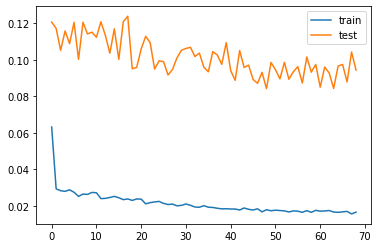

(41, 7)
(41, 7)
(41, 7)
score_train: [117.971] 111.8, 117.8, 125.7, 126.1, 116.4, 117.9, 109.2
(8, 1, 5)
score_test: [300.088] 309.7, 310.0, 44.4, 335.1, 427.0, 236.7, 292.8

RMSE test:  300.0876598339129 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.1583
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1127
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1189
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1223
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1173
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1140
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1260
Epoch 8/1000
41/41 [=========================

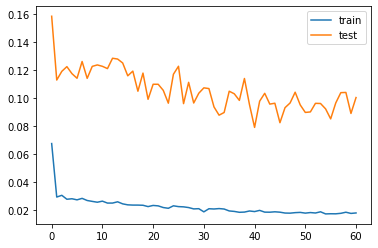

(41, 7)
(41, 7)
(41, 7)
score_train: [121.262] 114.7, 122.2, 131.0, 130.1, 119.2, 119.5, 110.8
(8, 1, 5)
score_test: [309.301] 310.0, 309.1, 36.9, 329.7, 444.4, 249.2, 329.2

RMSE test:  309.3008731838613 


Units CNN1:  223 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0808 - val_loss: 0.1809
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1127
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1254
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1228
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1236
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1232
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1230
Epoch 8/1000
41/41 [=========================

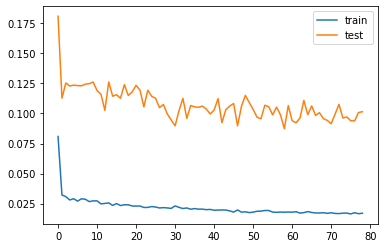

(41, 7)
(41, 7)
(41, 7)
score_train: [119.337] 114.1, 120.4, 127.7, 128.7, 119.1, 117.2, 106.7
(8, 1, 5)
score_test: [311.216] 323.3, 318.7, 54.4, 347.9, 462.9, 228.2, 285.5

RMSE test:  311.21627921801627 


Units CNN1:  251 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.1354
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1048
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1231
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1113
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1266
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1121
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0252 - val_loss: 0.1126
Epoch 8/1000
41/41 [========================

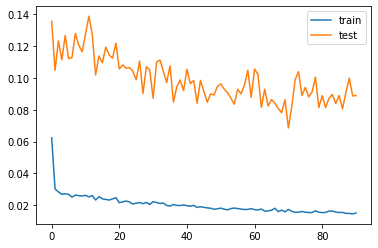

(41, 7)
(41, 7)
(41, 7)
score_train: [113.505] 107.1, 112.1, 122.7, 120.4, 111.2, 114.3, 105.6
(8, 1, 5)
score_test: [291.311] 300.8, 333.0, 51.7, 357.9, 392.2, 167.8, 282.6

RMSE test:  291.31089804091624 


Units CNN1:  191 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.1375
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1201
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1142
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1289
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1160
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1150
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1185
Epoch 8/1000
41/41 [========================

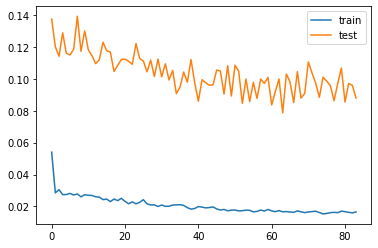

(41, 7)
(41, 7)
(41, 7)
score_train: [115.683] 107.9, 111.8, 126.5, 124.6, 112.3, 118.1, 106.9
(8, 1, 5)
score_test: [289.832] 293.3, 294.4, 16.0, 349.9, 419.5, 187.0, 285.7

RMSE test:  289.8318629847464 


Units CNN1:  126 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.1794
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1245
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1240
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1216
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1204
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1240
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1200
Epoch 8/1000
41/41 [=========================

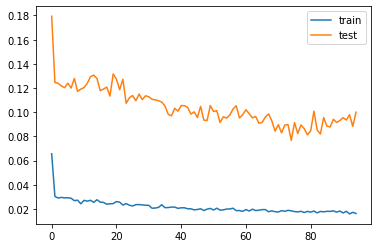

(41, 7)
(41, 7)
(41, 7)
score_train: [121.214] 115.8, 122.9, 128.9, 130.8, 122.1, 117.4, 109.0
(8, 1, 5)
score_test: [308.994] 306.4, 292.0, 20.3, 362.4, 461.3, 230.8, 302.3

RMSE test:  308.9936143054259 


Units CNN1:  127 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0735 - val_loss: 0.1798
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.1198
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.1237
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1163
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1143
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1270
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1208
Epoch 8/1000
41/41 [=========================

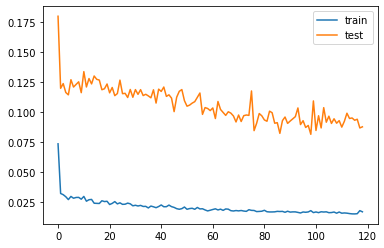

(41, 7)
(41, 7)
(41, 7)
score_train: [116.202] 110.5, 119.4, 123.5, 121.9, 112.8, 116.1, 108.4
(8, 1, 5)
score_test: [289.336] 295.8, 302.5, 26.7, 348.9, 416.9, 202.7, 263.9

RMSE test:  289.33639961477184 


Units CNN1:  127 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.2057
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0331 - val_loss: 0.1326
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1250
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1288
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1316
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1283
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1169
Epoch 8/1000
41/41 [========================

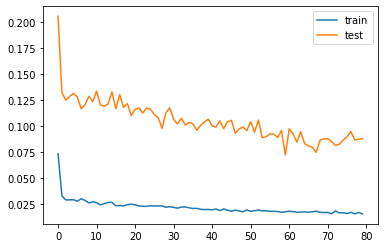

(41, 7)
(41, 7)
(41, 7)
score_train: [118.707] 112.8, 119.6, 128.3, 128.5, 115.4, 117.7, 107.0
(8, 1, 5)
score_test: [290.115] 293.2, 279.8, 41.6, 321.1, 424.7, 221.4, 301.2

RMSE test:  290.11470347921295 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0681 - val_loss: 0.1479
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1206
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1294
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1129
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1141
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1156
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1115
Epoch 8/1000
41/41 [========================

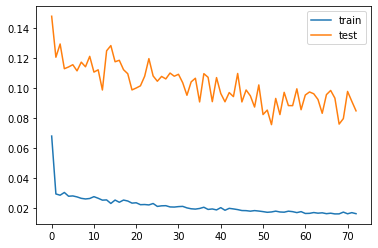

(41, 7)
(41, 7)
(41, 7)
score_train: [118.817] 115.5, 118.6, 127.7, 127.2, 115.3, 116.2, 110.2
(8, 1, 5)
score_test: [284.644] 274.7, 282.3, 18.2, 375.6, 408.8, 198.1, 253.4

RMSE test:  284.64352014555226 


Units CNN1:  247 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0709 - val_loss: 0.1491
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.1242
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1149
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1072
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1179
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1128
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1101
Epoch 8/1000
41/41 [========================

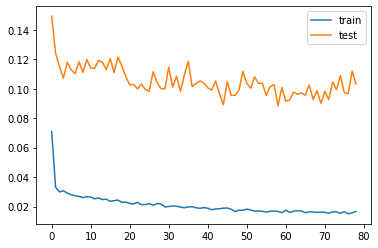

(41, 7)
(41, 7)
(41, 7)
score_train: [116.075] 112.3, 114.6, 125.5, 121.4, 113.4, 116.0, 108.4
(8, 1, 5)
score_test: [313.951] 314.3, 318.3, 37.6, 387.1, 428.7, 234.3, 316.1

RMSE test:  313.9512295175767 

gen	nevals	avg   	std    	min    	max    
0  	10    	291.92	5.73121	284.644	300.088

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0672 - val_loss: 0.1574
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1151
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1100
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1129
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1158
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1276
Epoch 7/1000
41/41 [==============================] - 0s 1ms/

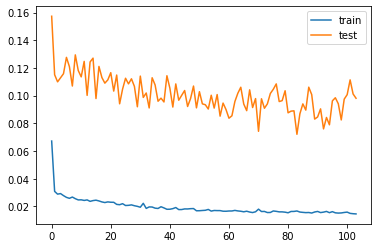

(41, 7)
(41, 7)
(41, 7)
score_train: [112.767] 108.5, 107.8, 122.6, 120.4, 109.3, 115.3, 104.2
(8, 1, 5)
score_test: [306.021] 326.7, 327.5, 47.8, 377.4, 395.9, 207.7, 311.4

RMSE test:  306.0206268997678 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0592 - val_loss: 0.1233
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1169
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1100
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1231
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1104
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1110
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.1189
Epoch 8/1000
41/41 [=========================

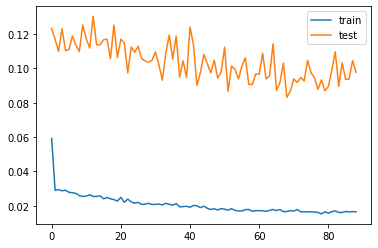

(41, 7)
(41, 7)
(41, 7)
score_train: [116.777] 111.8, 117.3, 125.1, 124.0, 113.0, 116.3, 109.0
(8, 1, 5)
score_test: [305.425] 311.8, 304.1, 47.1, 373.9, 428.5, 222.4, 297.0

RMSE test:  305.4249979171004 


Units CNN1:  239 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0659 - val_loss: 0.1471
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1072
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1183
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1180
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1210
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1175
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1131
Epoch 8/1000
41/41 [=========================

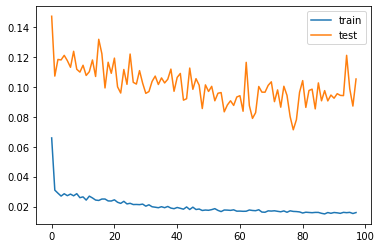

(41, 7)
(41, 7)
(41, 7)
score_train: [115.266] 109.8, 113.7, 124.2, 121.3, 110.5, 115.5, 111.0
(8, 1, 5)
score_test: [316.938] 305.8, 329.8, 62.6, 360.1, 429.8, 254.6, 343.1

RMSE test:  316.93808249195484 


Units CNN1:  127 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0666 - val_loss: 0.1712
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.1064
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1081
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1145
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1107
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1095
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1214
Epoch 8/1000
41/41 [========================

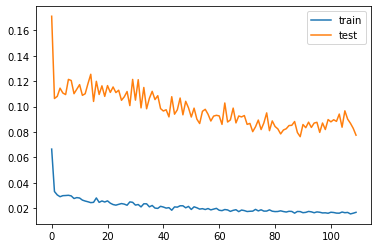

(41, 7)
(41, 7)
(41, 7)
score_train: [119.430] 113.9, 119.9, 129.7, 129.3, 116.4, 116.5, 108.6
(8, 1, 5)
score_test: [271.997] 274.1, 273.2, 10.0, 354.1, 366.4, 193.7, 266.1

RMSE test:  271.99654266950154 


Units CNN1:  250 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 10ms/step - loss: 0.0648 - val_loss: 0.1354
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1045
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1086
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1243
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1109
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1226
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1124
Epoch 8/1000
41/41 [=======================

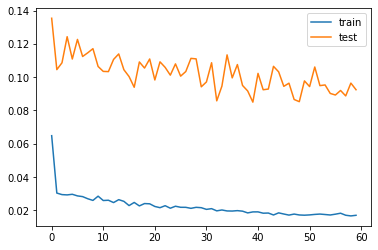

(41, 7)
(41, 7)
(41, 7)
score_train: [119.516] 113.6, 119.9, 129.1, 129.6, 116.0, 118.3, 108.6
(8, 1, 5)
score_test: [297.011] 323.3, 311.5, 22.9, 360.8, 401.7, 208.9, 283.3

RMSE test:  297.010575301481 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.1472
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1038
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1173
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1137
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1064
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1048
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1142
Epoch 8/1000
41/41 [==========================

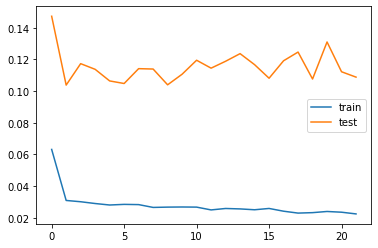

(41, 7)
(41, 7)
(41, 7)
score_train: [140.056] 137.2, 141.3, 143.3, 140.3, 139.4, 135.5, 143.2
(8, 1, 5)
score_test: [322.278] 340.5, 310.9, 37.8, 295.1, 518.4, 282.1, 278.5

RMSE test:  322.27755405479576 


Units CNN1:  247 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.1359
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1190
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1193
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1070
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1291
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.1116
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1034
Epoch 8/1000
41/41 [========================

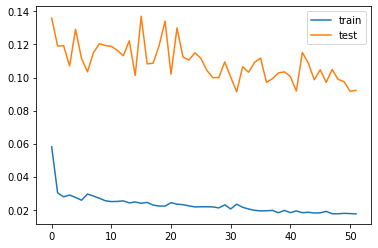

(41, 7)
(41, 7)
(41, 7)
score_train: [122.762] 117.5, 125.3, 131.5, 130.7, 121.8, 119.2, 112.1
(8, 1, 5)
score_test: [296.688] 306.4, 305.3, 23.9, 330.7, 443.5, 228.4, 265.1

RMSE test:  296.68755541041855 


Units CNN1:  251 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0668 - val_loss: 0.1541
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1111
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1248
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1157
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1321
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1215
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1210
Epoch 8/1000
41/41 [========================

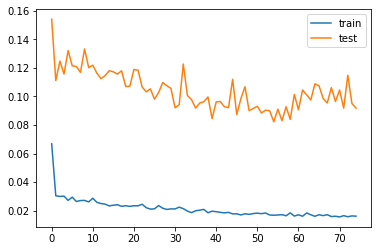

(41, 7)
(41, 7)
(41, 7)
score_train: [117.006] 111.1, 114.9, 128.3, 126.3, 113.1, 116.6, 107.3
(8, 1, 5)
score_test: [295.969] 305.3, 298.3, 27.9, 357.1, 418.8, 196.7, 297.7

RMSE test:  295.96935425943855 

1  	8     	279.358	7.57739	271.997	289.832

Units CNN1:  247 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.1716
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0338 - val_loss: 0.1242
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.1193
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1286
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1157
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.1171
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1185
E

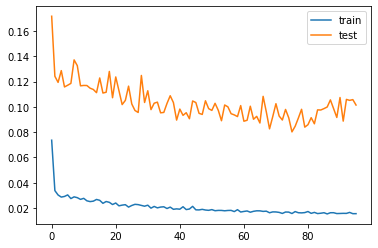

(41, 7)
(41, 7)
(41, 7)
score_train: [115.837] 112.0, 113.4, 125.0, 123.9, 112.2, 116.6, 106.6
(8, 1, 5)
score_test: [311.143] 299.7, 318.8, 68.8, 403.3, 406.2, 212.6, 329.7

RMSE test:  311.14298146918156 


Units CNN1:  253 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.1042
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0985
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1103
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1105
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1098
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1191
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1025
Epoch 8/1000
41/41 [========================

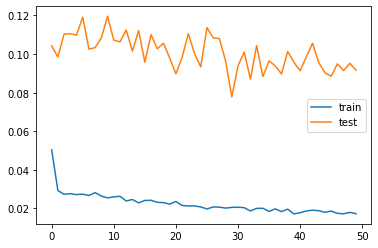

(41, 7)
(41, 7)
(41, 7)
score_train: [122.174] 117.7, 124.1, 132.3, 131.6, 119.5, 117.5, 111.0
(8, 1, 5)
score_test: [295.776] 319.9, 300.6, 7.2, 317.2, 427.3, 246.5, 275.2

RMSE test:  295.7760138505258 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0617 - val_loss: 0.1225
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1075
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1117
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1169
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1097
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1209
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.1144
Epoch 8/1000
41/41 [==========================

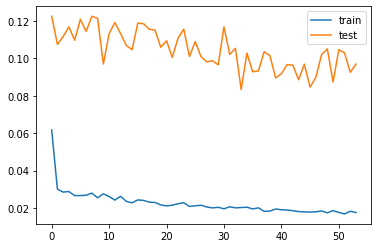

(41, 7)
(41, 7)
(41, 7)
score_train: [121.971] 116.1, 124.5, 130.9, 130.5, 121.1, 118.1, 111.3
(8, 1, 5)
score_test: [304.170] 311.1, 311.4, 29.5, 339.6, 446.3, 230.5, 292.2

RMSE test:  304.17038780255564 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0592 - val_loss: 0.1421
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1153
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1219
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1045
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1192
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1208
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1186
Epoch 8/1000
41/41 [========================

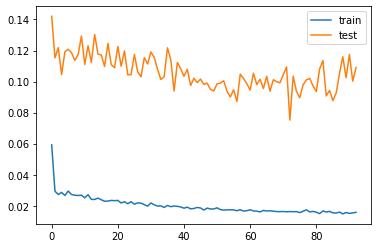

(41, 7)
(41, 7)
(41, 7)
score_train: [116.695] 109.8, 114.0, 127.0, 125.3, 111.7, 118.4, 109.2
(8, 1, 5)
score_test: [322.580] 338.0, 348.7, 71.7, 398.3, 413.9, 229.6, 323.7

RMSE test:  322.5796303329272 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0617 - val_loss: 0.1208
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1033
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1235
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1145
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.1316
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1071
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1082
Epoch 8/1000
41/41 [=========================

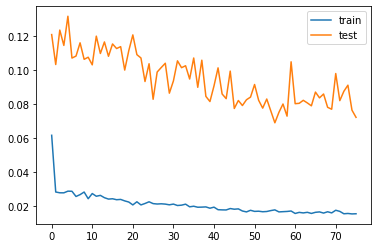

(41, 7)
(41, 7)
(41, 7)
score_train: [117.352] 111.9, 114.0, 128.4, 126.7, 115.3, 117.9, 105.5
(8, 1, 5)
score_test: [262.603] 283.2, 274.0, 25.0, 318.6, 365.8, 161.0, 256.0

RMSE test:  262.60284288825255 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.1504
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1194
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1236
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1128
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1214
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1132
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1272
Epoch 8/1000
41/41 [========================

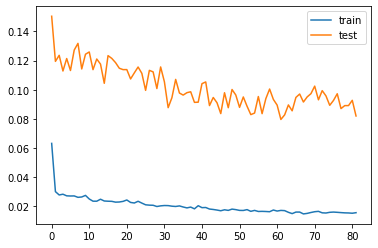

(41, 7)
(41, 7)
(41, 7)
score_train: [115.623] 109.2, 113.2, 125.6, 124.0, 113.7, 117.3, 104.8
(8, 1, 5)
score_test: [279.722] 297.8, 276.1, 13.6, 338.1, 399.1, 178.7, 277.7

RMSE test:  279.7215512870497 


Units CNN1:  127 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0898 - val_loss: 0.2310
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0348 - val_loss: 0.1331
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1173
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1227
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1319
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1180
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1154
Epoch 8/1000
41/41 [=========================

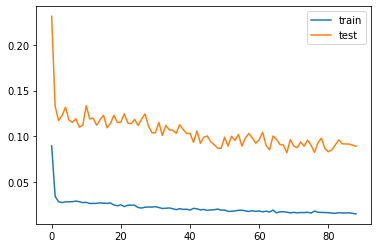

(41, 7)
(41, 7)
(41, 7)
score_train: [118.558] 113.7, 116.2, 127.4, 129.2, 117.2, 118.5, 106.2
(8, 1, 5)
score_test: [292.150] 318.7, 297.6, 18.4, 369.0, 406.8, 188.4, 264.4

RMSE test:  292.15014164739017 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0609 - val_loss: 0.1461
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1102
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1224
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1340
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1175
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1174
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0260 - val_loss: 0.1189
Epoch 8/1000
41/41 [========================

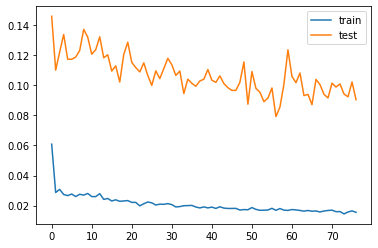

(41, 7)
(41, 7)
(41, 7)
score_train: [116.462] 111.6, 112.1, 125.8, 125.8, 114.3, 117.5, 106.7
(8, 1, 5)
score_test: [293.913] 316.2, 306.2, 23.4, 356.6, 410.0, 210.5, 266.1

RMSE test:  293.9126862916934 


Units CNN1:  243 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.1321
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1160
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1186
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1160
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1202
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1241
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.1183
Epoch 8/1000
41/41 [=========================

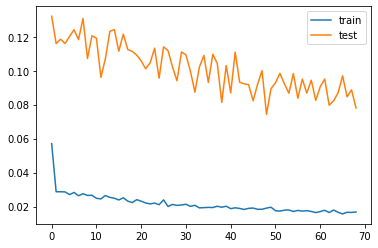

(41, 7)
(41, 7)
(41, 7)
score_train: [120.788] 115.9, 122.4, 129.5, 129.5, 118.9, 117.6, 110.5
(8, 1, 5)
score_test: [272.917] 286.5, 280.3, 15.2, 308.7, 398.3, 209.0, 250.6

RMSE test:  272.9169113817815 


Units CNN1:  223 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.1314
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1247
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1221
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1430
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1176
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1410
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1296
Epoch 8/1000
41/41 [=========================

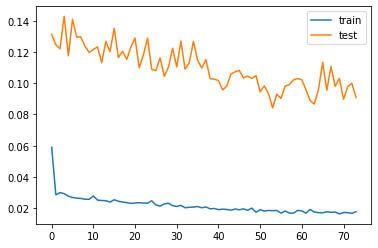

(41, 7)
(41, 7)
(41, 7)
score_train: [120.069] 113.0, 122.6, 128.0, 128.9, 119.1, 118.2, 109.3
(8, 1, 5)
score_test: [294.466] 301.1, 320.5, 27.9, 326.6, 424.0, 228.4, 272.4

RMSE test:  294.4656951710408 

2  	10    	266.36 	4.60195	262.603	271.997

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0726 - val_loss: 0.1563
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.1245
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1162
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1326
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1177
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1243
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1392
Ep

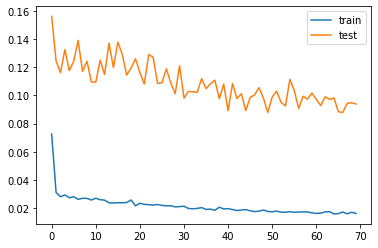

(41, 7)
(41, 7)
(41, 7)
score_train: [118.105] 112.3, 116.5, 127.3, 127.5, 117.6, 116.4, 107.7
(8, 1, 5)
score_test: [299.400] 327.5, 309.8, 30.6, 335.5, 406.1, 231.4, 303.8

RMSE test:  299.4004230331512 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 10ms/step - loss: 0.0719 - val_loss: 0.1548
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.1081
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1261
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1034
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1105
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1071
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1152
Epoch 8/1000
41/41 [========================

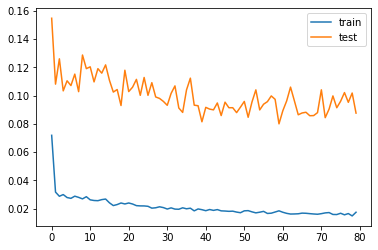

(41, 7)
(41, 7)
(41, 7)
score_train: [117.624] 113.2, 115.6, 126.7, 126.6, 114.0, 118.0, 108.1
(8, 1, 5)
score_test: [289.208] 277.0, 283.4, 30.4, 340.2, 419.3, 211.7, 301.8

RMSE test:  289.2080432364804 


Units CNN1:  254 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.1351
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1042
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1170
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1102
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.1204
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1134
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1345
Epoch 8/1000
41/41 [=========================

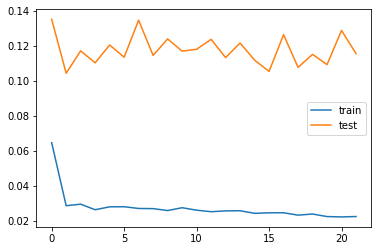

(41, 7)
(41, 7)
(41, 7)
score_train: [140.687] 132.7, 141.6, 143.7, 143.7, 139.7, 139.2, 143.8
(8, 1, 5)
score_test: [331.909] 330.8, 317.2, 46.5, 327.0, 522.0, 288.7, 310.1

RMSE test:  331.90877034063334 


Units CNN1:  191 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.1721
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1283
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1388
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1384
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1418
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1233
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1366
Epoch 8/1000
41/41 [========================

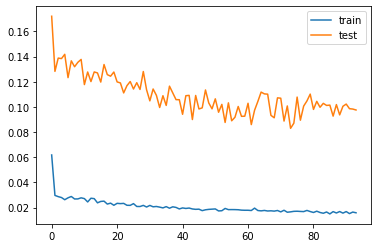

(41, 7)
(41, 7)
(41, 7)
score_train: [116.953] 111.9, 112.7, 126.8, 126.5, 114.1, 116.8, 108.5
(8, 1, 5)
score_test: [305.148] 323.3, 309.4, 57.5, 364.0, 420.3, 224.2, 298.1

RMSE test:  305.1484035299984 


Units CNN1:  223 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.1455
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1113
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1291
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1231
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1238
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1235
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1277
Epoch 8/1000
41/41 [=========================

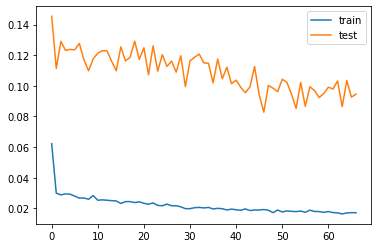

(41, 7)
(41, 7)
(41, 7)
score_train: [119.878] 115.5, 118.7, 128.9, 129.6, 119.3, 117.4, 108.4
(8, 1, 5)
score_test: [300.446] 295.0, 304.5, 29.7, 357.6, 450.7, 216.3, 271.0

RMSE test:  300.44596446283356 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0692 - val_loss: 0.1672
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1300
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1343
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1236
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1278
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1262
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1227
Epoch 8/1000
41/41 [========================

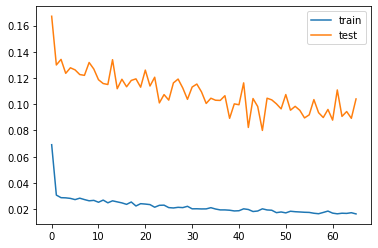

(41, 7)
(41, 7)
(41, 7)
score_train: [119.754] 113.8, 122.3, 128.9, 127.3, 117.2, 117.2, 110.5
(8, 1, 5)
score_test: [315.181] 318.8, 309.0, 39.3, 359.7, 443.5, 251.5, 327.8

RMSE test:  315.18062301979785 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.1278
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0998
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1016
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1040
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1104
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1014
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1051
Epoch 8/1000
41/41 [========================

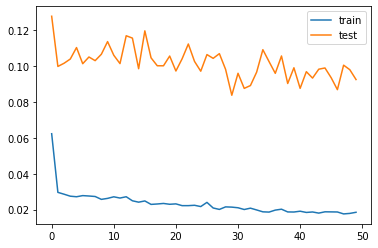

(41, 7)
(41, 7)
(41, 7)
score_train: [123.659] 119.7, 124.9, 131.7, 131.5, 121.0, 120.3, 115.6
(8, 1, 5)
score_test: [297.190] 316.2, 302.2, 31.2, 316.2, 441.7, 242.2, 268.7

RMSE test:  297.19030860385175 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0685 - val_loss: 0.1463
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1122
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1213
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1158
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1222
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1073
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1139
Epoch 8/1000
41/41 [========================

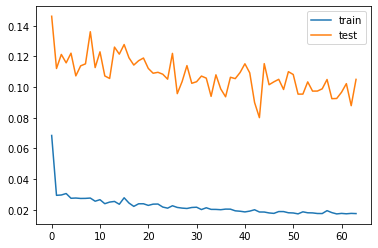

(41, 7)
(41, 7)
(41, 7)
score_train: [122.570] 115.3, 120.6, 131.5, 131.8, 123.7, 121.1, 112.6
(8, 1, 5)
score_test: [316.669] 324.2, 306.7, 27.2, 356.5, 465.9, 254.6, 305.1

RMSE test:  316.6693113940909 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0608 - val_loss: 0.1368
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1104
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1025
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1250
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1161
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.1270
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0258 - val_loss: 0.1186
Epoch 8/1000
41/41 [=========================

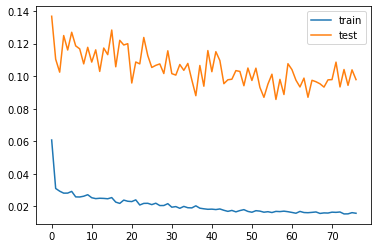

(41, 7)
(41, 7)
(41, 7)
score_train: [115.048] 109.0, 113.0, 125.8, 123.8, 112.8, 115.5, 103.8
(8, 1, 5)
score_test: [305.657] 319.2, 321.6, 30.3, 373.4, 425.3, 220.4, 280.7

RMSE test:  305.65663712008524 

3  	9     	263.542	2.81811	262.603	271.997

Units CNN1:  253 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 10ms/step - loss: 0.0682 - val_loss: 0.1590
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1200
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1125
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1080
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1288
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1122
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1173


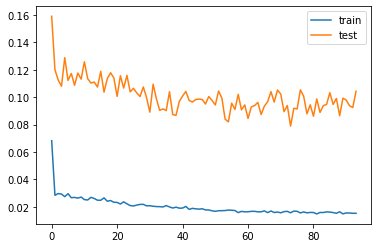

(41, 7)
(41, 7)
(41, 7)
score_train: [115.423] 110.5, 107.5, 125.7, 125.4, 112.2, 117.2, 107.8
(8, 1, 5)
score_test: [315.454] 321.3, 338.3, 85.8, 395.5, 421.0, 212.5, 304.6

RMSE test:  315.4538539630865 


Units CNN1:  249 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.1445
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1162
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1354
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1185
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1207
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1240
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1086
Epoch 8/1000
41/41 [=========================

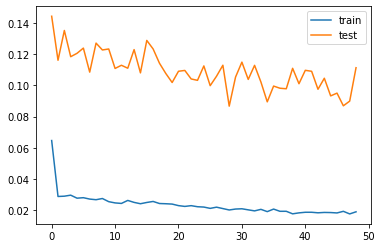

(41, 7)
(41, 7)
(41, 7)
score_train: [127.467] 121.0, 126.3, 137.9, 135.2, 124.0, 124.5, 122.4
(8, 1, 5)
score_test: [326.113] 347.1, 289.3, 48.8, 386.0, 457.0, 247.9, 344.3

RMSE test:  326.1132807208694 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.1225
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1183
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1159
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1133
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1187
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1177
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1194
Epoch 8/1000
41/41 [=========================

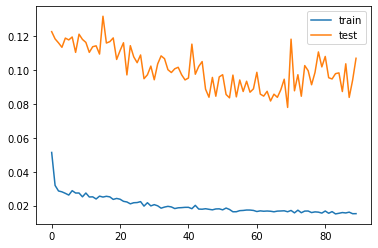

(41, 7)
(41, 7)
(41, 7)
score_train: [116.034] 109.8, 109.0, 125.0, 125.6, 115.7, 118.0, 107.6
(8, 1, 5)
score_test: [319.348] 315.7, 326.6, 56.8, 369.8, 434.4, 256.1, 336.5

RMSE test:  319.3481017457641 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0509 - val_loss: 0.1139
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0305 - val_loss: 0.1191
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1228
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.1193
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1116
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1170
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1197
Epoch 8/1000
41/41 [=========================

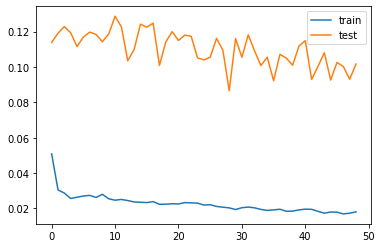

(41, 7)
(41, 7)
(41, 7)
score_train: [123.808] 118.7, 126.7, 132.4, 130.8, 124.9, 119.3, 112.5
(8, 1, 5)
score_test: [311.537] 326.8, 329.5, 23.1, 347.3, 441.3, 250.2, 292.6

RMSE test:  311.5367340598327 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0731 - val_loss: 0.1487
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1312
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0315 - val_loss: 0.1204
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1113
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1201
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1222
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1085
Epoch 8/1000
41/41 [=========================

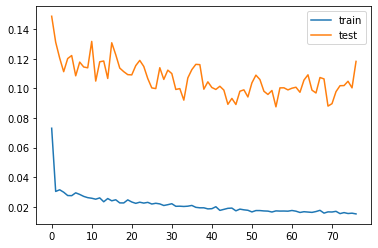

(41, 7)
(41, 7)
(41, 7)
score_train: [117.901] 112.2, 112.2, 126.4, 128.2, 115.8, 119.0, 110.0
(8, 1, 5)
score_test: [335.931] 350.2, 323.5, 51.9, 414.6, 451.7, 250.1, 348.5

RMSE test:  335.93126429731313 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0696 - val_loss: 0.1343
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1067
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1145
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1128
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1128
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1309
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1216
Epoch 8/1000
41/41 [========================

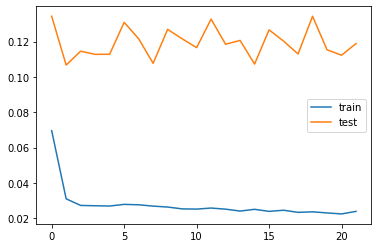

(41, 7)
(41, 7)
(41, 7)
score_train: [139.848] 135.9, 139.7, 143.0, 141.3, 138.1, 140.9, 139.9
(8, 1, 5)
score_test: [336.862] 348.2, 328.2, 35.6, 337.1, 520.8, 302.3, 296.3

RMSE test:  336.86194704062336 


Units CNN1:  254 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.1253
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1207
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1132
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1090
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1132
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1282
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1214
Epoch 8/1000
41/41 [========================

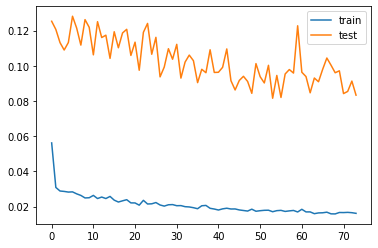

(41, 7)
(41, 7)
(41, 7)
score_train: [118.451] 112.5, 115.3, 128.3, 130.4, 117.6, 116.4, 107.0
(8, 1, 5)
score_test: [281.990] 314.3, 277.8, 12.7, 319.0, 392.6, 199.6, 291.2

RMSE test:  281.98975828962074 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0698 - val_loss: 0.1486
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1098
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1160
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1141
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1053
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1249
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1280
Epoch 8/1000
41/41 [========================

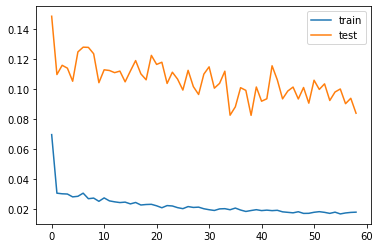

(41, 7)
(41, 7)
(41, 7)
score_train: [122.861] 117.7, 127.8, 130.5, 130.1, 119.8, 119.2, 113.8
(8, 1, 5)
score_test: [283.232] 281.7, 291.6, 35.3, 299.7, 427.5, 225.3, 269.4

RMSE test:  283.2323930050507 

4  	8     	263.542	2.81811	262.603	271.997

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 11ms/step - loss: 0.0600 - val_loss: 0.1339
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1108
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1323
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1092
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1238
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1210
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1144
E

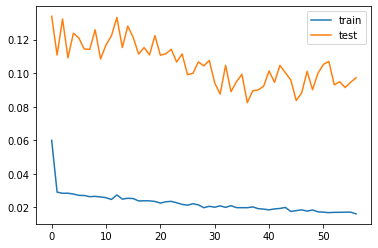

(41, 7)
(41, 7)
(41, 7)
score_train: [120.934] 117.4, 122.6, 130.2, 130.2, 117.6, 117.5, 109.6
(8, 1, 5)
score_test: [304.730] 321.5, 304.8, 16.6, 350.8, 439.6, 228.1, 291.8

RMSE test:  304.73007825493147 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.1330
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.1194
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0314 - val_loss: 0.1226
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1208
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.1280
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1237
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1228
Epoch 8/1000
41/41 [========================

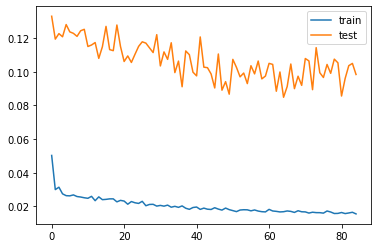

(41, 7)
(41, 7)
(41, 7)
score_train: [116.411] 110.3, 114.5, 126.1, 125.6, 115.3, 115.7, 106.2
(8, 1, 5)
score_test: [306.426] 315.4, 317.3, 37.1, 363.8, 426.2, 220.7, 305.1

RMSE test:  306.42575487365133 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0649 - val_loss: 0.1481
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1127
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1243
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1197
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1232
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1201
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1107
Epoch 8/1000
41/41 [========================

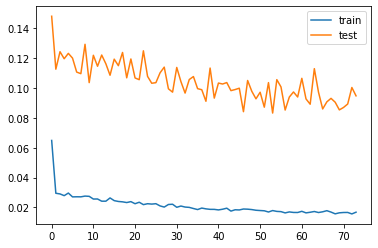

(41, 7)
(41, 7)
(41, 7)
score_train: [117.888] 111.6, 116.6, 127.2, 127.1, 115.4, 117.3, 108.6
(8, 1, 5)
score_test: [300.785] 318.7, 297.7, 13.7, 336.2, 437.8, 231.2, 291.2

RMSE test:  300.78480222842205 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.1458
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1070
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1271
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1061
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1132
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1222
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1065
Epoch 8/1000
41/41 [========================

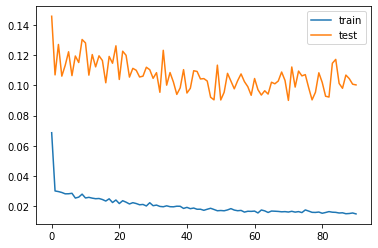

(41, 7)
(41, 7)
(41, 7)
score_train: [114.261] 109.9, 110.2, 123.8, 121.7, 110.9, 115.0, 107.1
(8, 1, 5)
score_test: [309.440] 302.9, 309.7, 73.5, 398.8, 437.9, 197.3, 295.6

RMSE test:  309.43965172579846 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.1360
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0911
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1054
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1102
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1175
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1156
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1150
Epoch 8/1000
41/41 [========================

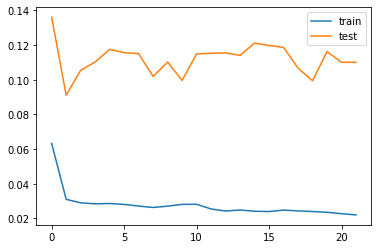

(41, 7)
(41, 7)
(41, 7)
score_train: [140.178] 137.3, 140.2, 143.2, 141.5, 136.8, 138.0, 144.1
(8, 1, 5)
score_test: [324.061] 365.6, 321.5, 34.8, 322.5, 468.3, 284.4, 304.4

RMSE test:  324.0608891263089 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0678 - val_loss: 0.1468
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1096
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1229
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1246
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1143
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1215
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1132
Epoch 8/1000
41/41 [=========================

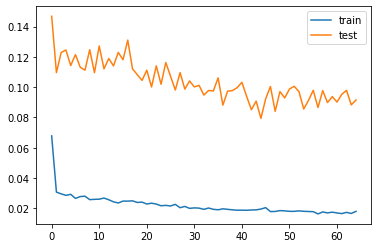

(41, 7)
(41, 7)
(41, 7)
score_train: [120.316] 115.6, 120.4, 130.3, 128.9, 118.9, 118.6, 108.1
(8, 1, 5)
score_test: [295.594] 305.7, 303.7, 58.8, 347.0, 407.3, 210.9, 302.8

RMSE test:  295.5937856999682 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.1282
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1092
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1285
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1031
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1347
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1348
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0266 - val_loss: 0.1102
Epoch 8/1000
41/41 [=========================

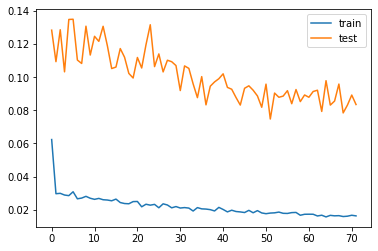

(41, 7)
(41, 7)
(41, 7)
score_train: [117.797] 111.0, 116.2, 127.5, 127.9, 116.5, 116.5, 107.6
(8, 1, 5)
score_test: [282.158] 307.4, 271.4, 32.7, 320.7, 400.0, 207.2, 286.8

RMSE test:  282.15800146920765 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.1522
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.1144
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1232
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.1130
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1197
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1251
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1240
Epoch 8/1000
41/41 [========================

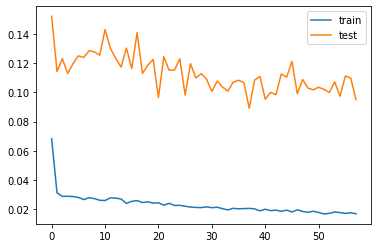

(41, 7)
(41, 7)
(41, 7)
score_train: [122.523] 118.6, 123.8, 131.3, 130.9, 120.6, 119.4, 111.8
(8, 1, 5)
score_test: [301.283] 323.3, 325.6, 39.4, 303.3, 456.6, 227.0, 267.0

RMSE test:  301.28275305349746 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 11ms/step - loss: 0.0632 - val_loss: 0.1370
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1171
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1218
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1269
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1126
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.1308
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1152
Epoch 8/1000
41/41 [=======================

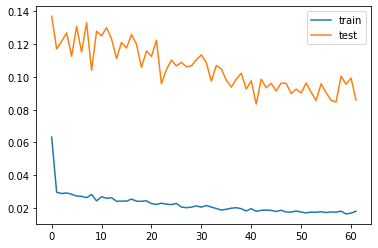

(41, 7)
(41, 7)
(41, 7)
score_train: [120.816] 113.4, 122.8, 131.1, 131.0, 119.7, 117.7, 108.2
(8, 1, 5)
score_test: [286.236] 306.6, 308.0, 10.2, 319.3, 403.9, 216.7, 269.4

RMSE test:  286.2363458732208 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.1216
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1267
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1242
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1193
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1191
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1032
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1199
Epoch 8/1000
41/41 [=========================

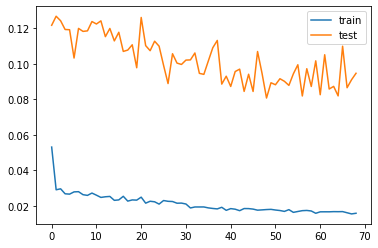

(41, 7)
(41, 7)
(41, 7)
score_train: [117.327] 112.0, 117.2, 127.1, 125.9, 115.2, 115.8, 106.6
(8, 1, 5)
score_test: [300.571] 304.8, 321.7, 49.6, 343.6, 427.9, 220.6, 289.2

RMSE test:  300.5706289989173 

5  	10    	262.603	5.68434e-14	262.603	262.603

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.1158
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0321 - val_loss: 0.1174
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1168
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1292
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1114
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1143
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.122

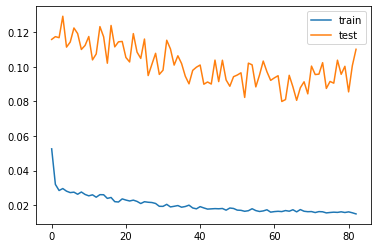

(41, 7)
(41, 7)
(41, 7)
score_train: [117.189] 108.6, 110.8, 126.2, 127.4, 114.8, 121.0, 109.8
(8, 1, 5)
score_test: [324.206] 324.4, 320.9, 64.9, 358.7, 453.8, 259.6, 348.3

RMSE test:  324.2059316833446 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0659 - val_loss: 0.1360
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1169
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1135
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1028
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1118
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1257
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1213
Epoch 8/1000
41/41 [=========================

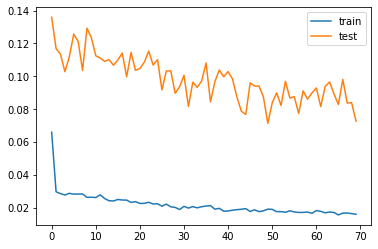

(41, 7)
(41, 7)
(41, 7)
score_train: [121.292] 118.7, 122.1, 128.8, 128.1, 117.2, 122.5, 110.7
(8, 1, 5)
score_test: [263.341] 253.3, 271.1, 10.9, 323.2, 396.9, 158.9, 245.7

RMSE test:  263.3405650334235 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.1510
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0319 - val_loss: 0.1113
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1078
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1301
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1144
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1247
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1272
Epoch 8/1000
41/41 [=========================

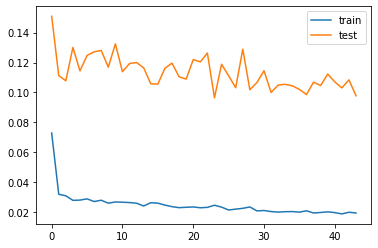

(41, 7)
(41, 7)
(41, 7)
score_train: [127.469] 124.3, 131.3, 134.8, 134.4, 127.1, 122.4, 116.9
(8, 1, 5)
score_test: [305.487] 324.0, 327.4, 51.6, 287.6, 473.9, 248.7, 263.1

RMSE test:  305.4869223110559 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.1347
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1130
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1089
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1100
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.1193
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1181
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1209
Epoch 8/1000
41/41 [=========================

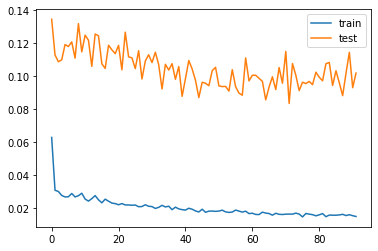

(41, 7)
(41, 7)
(41, 7)
score_train: [113.758] 108.4, 107.9, 124.4, 121.8, 112.2, 116.0, 104.1
(8, 1, 5)
score_test: [312.001] 321.2, 304.2, 30.1, 386.2, 427.3, 234.9, 312.9

RMSE test:  312.0013016499228 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0695 - val_loss: 0.1471
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1099
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1143
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1054
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1298
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1072
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.1214
Epoch 8/1000
41/41 [=========================

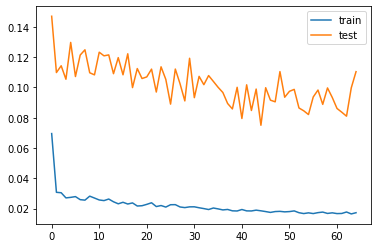

(41, 7)
(41, 7)
(41, 7)
score_train: [125.805] 113.9, 119.5, 138.0, 135.3, 129.9, 125.8, 116.1
(8, 1, 5)
score_test: [324.681] 325.3, 310.2, 72.8, 383.9, 462.6, 271.1, 309.3

RMSE test:  324.6810662497892 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0711 - val_loss: 0.1561
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0313 - val_loss: 0.1167
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1315
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1332
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.1118
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1193
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1160
Epoch 8/1000
41/41 [=========================

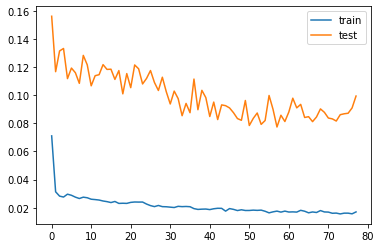

(41, 7)
(41, 7)
(41, 7)
score_train: [118.945] 110.6, 118.5, 125.7, 125.9, 116.8, 119.8, 114.5
(8, 1, 5)
score_test: [308.024] 296.3, 310.0, 30.7, 351.0, 435.1, 244.8, 326.9

RMSE test:  308.0241863753319 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 11ms/step - loss: 0.0635 - val_loss: 0.1297
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1083
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1292
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1033
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1123
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1189
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1215
Epoch 8/1000
41/41 [========================

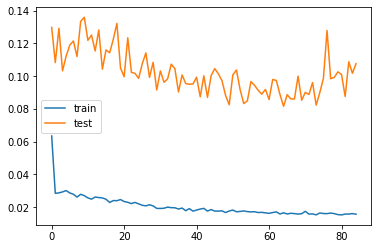

(41, 7)
(41, 7)
(41, 7)
score_train: [115.867] 109.1, 113.2, 126.7, 127.2, 109.6, 116.2, 107.4
(8, 1, 5)
score_test: [320.531] 321.6, 347.7, 79.5, 391.7, 413.8, 226.3, 335.5

RMSE test:  320.5307789190388 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.1322
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1072
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1343
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1169
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1097
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1215
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1300
Epoch 8/1000
41/41 [=========================

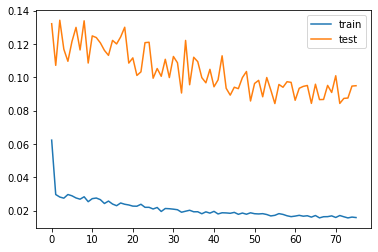

(41, 7)
(41, 7)
(41, 7)
score_train: [118.087] 112.2, 118.7, 129.0, 126.0, 112.7, 117.9, 108.7
(8, 1, 5)
score_test: [301.138] 319.2, 308.4, 31.2, 376.9, 411.0, 220.7, 277.7

RMSE test:  301.1381429411206 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.1614
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1051
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1157
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1267
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1126
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1173
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1291
Epoch 8/1000
41/41 [=========================

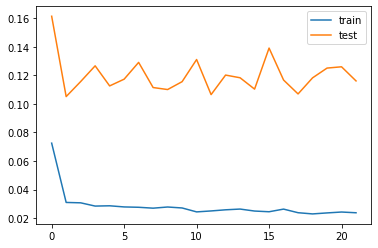

(41, 7)
(41, 7)
(41, 7)
score_train: [141.089] 135.2, 141.9, 144.6, 142.1, 136.3, 143.7, 143.5
(8, 1, 5)
score_test: [332.910] 348.5, 335.8, 69.0, 309.9, 490.2, 309.7, 323.3

RMSE test:  332.90964934584906 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0561 - val_loss: 0.1254
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0306 - val_loss: 0.1194
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1135
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1145
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.1161
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1277
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1182
Epoch 8/1000
41/41 [========================

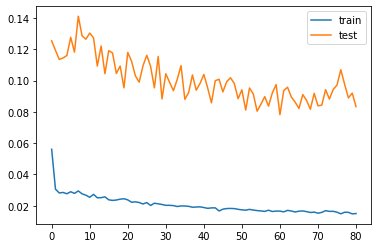

(41, 7)
(41, 7)
(41, 7)
score_train: [116.429] 112.3, 116.4, 124.9, 124.3, 111.3, 117.3, 107.4
(8, 1, 5)
score_test: [282.121] 278.5, 294.7, 33.7, 372.2, 382.1, 202.0, 257.4

RMSE test:  282.12118914407085 

6  	10    	262.603	5.68434e-14	262.603	262.603

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0687 - val_loss: 0.1341
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1189
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1084
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1230
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.1341
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1119
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.11

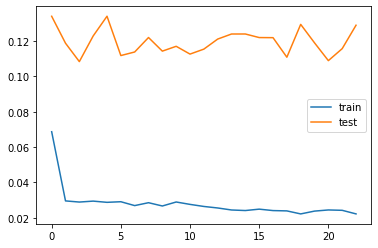

(41, 7)
(41, 7)
(41, 7)
score_train: [141.439] 135.4, 140.1, 147.3, 142.8, 139.3, 140.8, 144.1
(8, 1, 5)
score_test: [350.965] 354.9, 312.0, 49.7, 349.8, 545.7, 318.8, 338.6

RMSE test:  350.965120926613 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0681 - val_loss: 0.1579
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1119
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1249
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1200
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1191
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1335
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1147
Epoch 8/1000
41/41 [==========================

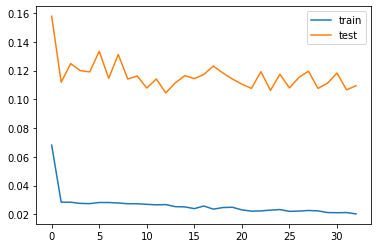

(41, 7)
(41, 7)
(41, 7)
score_train: [133.671] 129.5, 137.1, 138.9, 138.7, 131.3, 131.0, 128.9
(8, 1, 5)
score_test: [323.290] 341.8, 317.9, 47.4, 304.6, 496.6, 300.1, 286.5

RMSE test:  323.29019045553247 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.1384
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1143
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1230
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1203
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1182
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1148
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1222
Epoch 8/1000
41/41 [========================

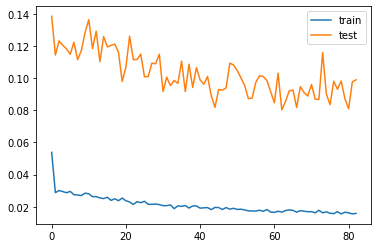

(41, 7)
(41, 7)
(41, 7)
score_train: [116.872] 109.9, 116.0, 126.7, 126.0, 115.4, 116.5, 106.3
(8, 1, 5)
score_test: [307.331] 303.1, 297.7, 56.2, 372.9, 433.1, 233.0, 310.8

RMSE test:  307.33115221613895 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0563 - val_loss: 0.1211
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1152
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1150
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1233
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0267 - val_loss: 0.1240
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1307
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1278
Epoch 8/1000
41/41 [========================

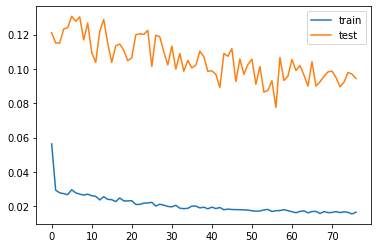

(41, 7)
(41, 7)
(41, 7)
score_train: [116.815] 110.5, 113.9, 126.4, 128.7, 113.6, 116.6, 106.1
(8, 1, 5)
score_test: [300.208] 295.0, 322.8, 52.7, 341.2, 418.0, 215.0, 315.4

RMSE test:  300.20807288487094 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0687 - val_loss: 0.1659
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0302 - val_loss: 0.1108
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1401
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1243
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1335
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1227
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1323
Epoch 8/1000
41/41 [========================

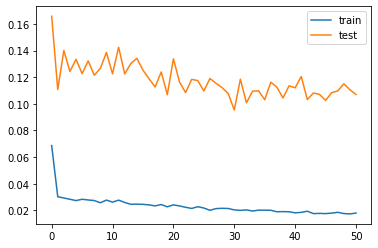

(41, 7)
(41, 7)
(41, 7)
score_train: [123.003] 118.1, 125.3, 132.1, 130.9, 122.3, 119.5, 111.5
(8, 1, 5)
score_test: [319.589] 339.1, 306.6, 21.2, 350.5, 457.8, 266.5, 319.5

RMSE test:  319.58875548582904 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0657 - val_loss: 0.1455
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1131
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.1221
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1199
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.1217
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1109
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1185
Epoch 8/1000
41/41 [========================

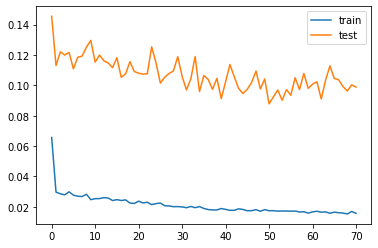

(41, 7)
(41, 7)
(41, 7)
score_train: [117.507] 112.0, 118.4, 126.3, 124.4, 114.9, 116.1, 109.5
(8, 1, 5)
score_test: [307.160] 315.0, 298.0, 31.9, 376.1, 430.0, 211.6, 316.7

RMSE test:  307.1601149510854 

7  	6     	262.603	5.68434e-14	262.603	262.603

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0603 - val_loss: 0.1268
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.1165
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1090
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.1157
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1326
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0263 - val_loss: 0.1173
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.123

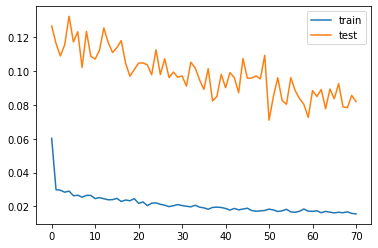

(41, 7)
(41, 7)
(41, 7)
score_train: [117.758] 111.7, 119.8, 126.8, 126.1, 114.0, 116.4, 108.1
(8, 1, 5)
score_test: [279.852] 285.1, 274.9, 15.2, 357.7, 400.1, 184.8, 262.6

RMSE test:  279.85202019614786 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0588 - val_loss: 0.1273
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.1216
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.1211
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1279
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.1138
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1291
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.1146
Epoch 8/1000
41/41 [========================

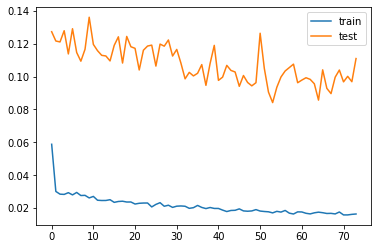

(41, 7)
(41, 7)
(41, 7)
score_train: [119.303] 112.9, 118.0, 127.6, 126.8, 119.2, 119.9, 109.4
(8, 1, 5)
score_test: [325.406] 347.5, 330.4, 28.7, 348.1, 466.6, 265.8, 317.8

RMSE test:  325.406104569651 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0644 - val_loss: 0.1501
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1302
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.1319
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1277
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1325
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1234
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1232
Epoch 8/1000
41/41 [==========================

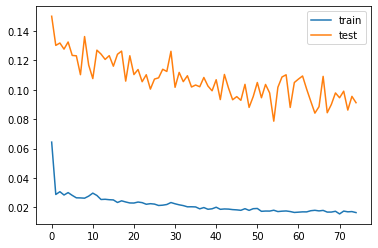

(41, 7)
(41, 7)
(41, 7)
score_train: [118.542] 113.0, 118.2, 128.1, 128.1, 117.3, 116.5, 107.1
(8, 1, 5)
score_test: [295.094] 311.2, 308.0, 17.6, 318.5, 434.6, 233.4, 269.7

RMSE test:  295.0936769139412 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.1363
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1073
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.1314
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1084
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1173
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1277
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1190
Epoch 8/1000
41/41 [=========================

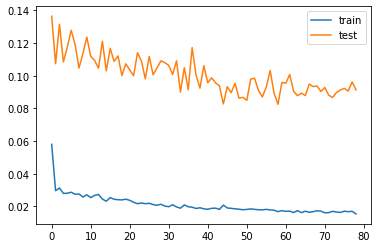

(41, 7)
(41, 7)
(41, 7)
score_train: [116.702] 111.0, 117.0, 126.7, 125.1, 112.4, 115.9, 107.5
(8, 1, 5)
score_test: [295.097] 294.1, 290.8, 28.4, 342.9, 409.8, 230.5, 314.8

RMSE test:  295.09699231477737 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0982
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1029
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.1163
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1032
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1029
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.1029
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1104
Epoch 8/1000
41/41 [========================

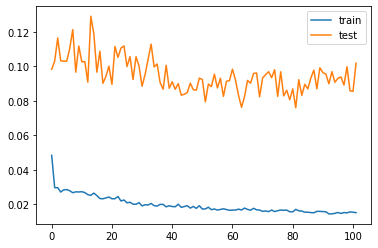

(41, 7)
(41, 7)
(41, 7)
score_train: [115.197] 108.9, 109.6, 124.1, 121.6, 113.6, 118.9, 108.6
(8, 1, 5)
score_test: [311.667] 314.7, 327.1, 64.3, 383.5, 416.8, 215.0, 320.6

RMSE test:  311.6666621020675 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0726 - val_loss: 0.1637
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0318 - val_loss: 0.1103
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.1275
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.1201
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.1169
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1192
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.1108
Epoch 8/1000
41/41 [=========================

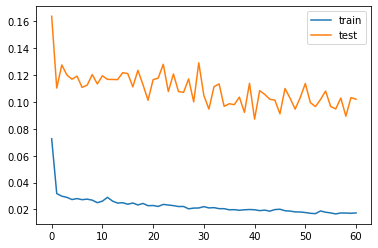

(41, 7)
(41, 7)
(41, 7)
score_train: [121.154] 118.7, 122.2, 128.9, 129.4, 117.5, 118.5, 112.0
(8, 1, 5)
score_test: [312.032] 350.2, 306.1, 28.6, 339.0, 439.6, 252.4, 304.1

RMSE test:  312.0322919098352 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.1138
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1213
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1117
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1185
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1249
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.1142
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1200
Epoch 8/1000
41/41 [=========================

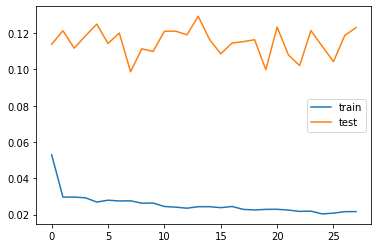

(41, 7)
(41, 7)
(41, 7)
score_train: [135.086] 131.8, 134.9, 141.2, 137.9, 136.6, 131.7, 131.3
(8, 1, 5)
score_test: [342.644] 345.5, 327.9, 31.2, 348.4, 531.1, 293.1, 323.3

RMSE test:  342.64371673548874 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 11ms/step - loss: 0.0608 - val_loss: 0.1334
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1162
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1260
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1227
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0311 - val_loss: 0.1361
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1223
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1292
Epoch 8/1000
41/41 [=======================

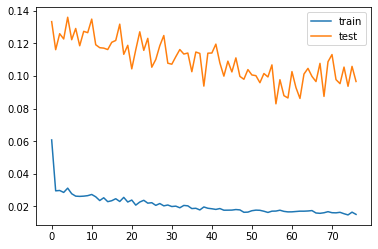

(41, 7)
(41, 7)
(41, 7)
score_train: [116.099] 110.9, 114.3, 126.7, 124.1, 112.6, 115.3, 107.4
(8, 1, 5)
score_test: [303.709] 301.5, 341.9, 32.4, 357.1, 409.2, 234.5, 294.7

RMSE test:  303.70866396627946 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0646 - val_loss: 0.1390
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1016
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1298
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1338
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1229
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1156
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1449
Epoch 8/1000
41/41 [========================

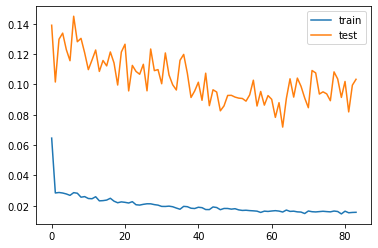

(41, 7)
(41, 7)
(41, 7)
score_train: [116.316] 111.1, 111.4, 125.1, 124.8, 114.5, 118.1, 108.1
(8, 1, 5)
score_test: [314.118] 319.4, 314.3, 69.0, 396.0, 425.8, 239.3, 299.5

RMSE test:  314.1175585667549 

8  	9     	262.603	5.68434e-14	262.603	262.603

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.1038
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1156
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0317 - val_loss: 0.1077
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1033
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1211
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1069
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0273 - val_loss: 0.115

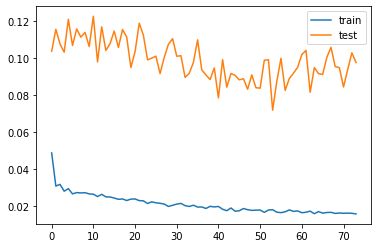

(41, 7)
(41, 7)
(41, 7)
score_train: [117.293] 111.5, 115.8, 126.6, 125.8, 113.3, 118.0, 108.9
(8, 1, 5)
score_test: [305.339] 312.1, 287.8, 16.5, 373.0, 407.7, 238.4, 331.6

RMSE test:  305.33851484487127 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0639 - val_loss: 0.1510
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1091
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1286
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1247
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1284
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0263 - val_loss: 0.1263
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1275
Epoch 8/1000
41/41 [========================

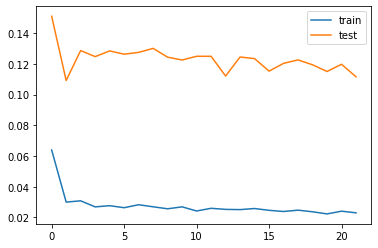

(41, 7)
(41, 7)
(41, 7)
score_train: [140.149] 133.5, 143.6, 143.4, 141.4, 138.8, 138.1, 142.0
(8, 1, 5)
score_test: [326.283] 348.0, 335.0, 32.4, 299.2, 486.5, 300.8, 306.8

RMSE test:  326.2827298613272 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.1341
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.1239
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1154
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1111
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.1108
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1388
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1169
Epoch 8/1000
41/41 [=========================

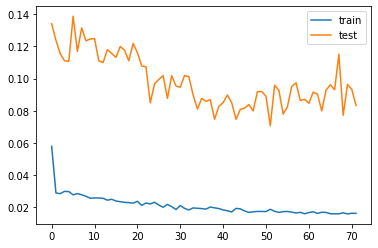

(41, 7)
(41, 7)
(41, 7)
score_train: [117.829] 110.8, 114.4, 126.8, 129.3, 118.0, 117.8, 105.9
(8, 1, 5)
score_test: [281.985] 305.1, 269.5, 36.6, 336.9, 387.5, 195.9, 296.0

RMSE test:  281.98463590771473 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.1185
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1075
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1187
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1095
Epoch 5/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.1136
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1067
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1155
Epoch 8/1000
41/41 [========================

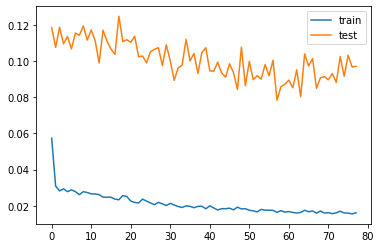

(41, 7)
(41, 7)
(41, 7)
score_train: [117.824] 110.9, 117.7, 128.2, 126.6, 115.9, 115.8, 108.3
(8, 1, 5)
score_test: [304.413] 300.5, 277.0, 67.9, 372.3, 443.8, 219.3, 305.5

RMSE test:  304.4131412503243 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0729 - val_loss: 0.1629
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0303 - val_loss: 0.1098
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1241
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0276 - val_loss: 0.1090
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1077
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1133
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1089
Epoch 8/1000
41/41 [=========================

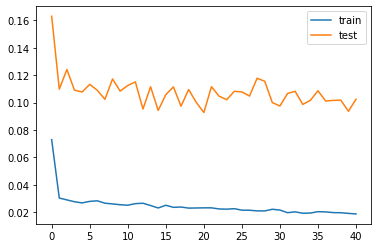

(41, 7)
(41, 7)
(41, 7)
score_train: [127.746] 123.8, 130.6, 136.1, 134.7, 124.8, 124.6, 118.5
(8, 1, 5)
score_test: [312.678] 326.3, 319.0, 22.1, 327.5, 462.6, 261.7, 293.0

RMSE test:  312.678092844227 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.1433
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0308 - val_loss: 0.1219
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1324
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1164
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1134
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1117
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1059
Epoch 8/1000
41/41 [==========================

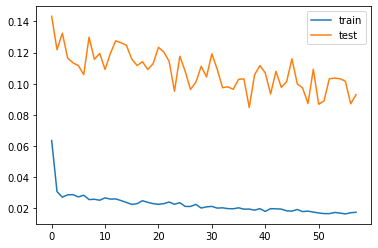

(41, 7)
(41, 7)
(41, 7)
score_train: [120.097] 116.0, 119.1, 130.2, 127.8, 118.0, 118.1, 110.4
(8, 1, 5)
score_test: [297.950] 299.9, 298.2, 35.9, 360.9, 443.1, 217.1, 259.8

RMSE test:  297.94956834168994 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.1128
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1138
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1070
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1255
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0282 - val_loss: 0.1220
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0272 - val_loss: 0.1176
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1213
Epoch 8/1000
41/41 [========================

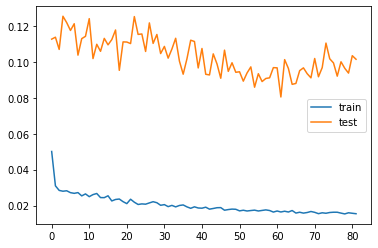

(41, 7)
(41, 7)
(41, 7)
score_train: [116.474] 110.2, 112.9, 128.2, 127.0, 112.9, 115.5, 106.9
(8, 1, 5)
score_test: [311.318] 312.4, 316.0, 69.2, 387.3, 418.8, 223.4, 317.6

RMSE test:  311.31784627674557 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0605 - val_loss: 0.1472
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1121
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.1226
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.1182
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1334
Epoch 6/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.1185
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.1188
Epoch 8/1000
41/41 [========================

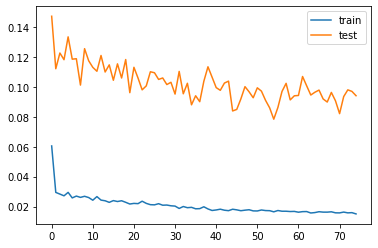

(41, 7)
(41, 7)
(41, 7)
score_train: [115.703] 111.6, 114.2, 124.5, 122.7, 112.8, 116.5, 106.5
(8, 1, 5)
score_test: [299.671] 323.1, 313.9, 54.9, 387.3, 390.5, 202.6, 281.3

RMSE test:  299.67078939781914 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.1472
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1225
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1238
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1213
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1437
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1143
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1209
Epoch 8/1000
41/41 [========================

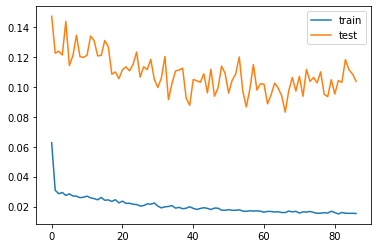

(41, 7)
(41, 7)
(41, 7)
score_train: [114.832] 109.1, 114.0, 123.5, 121.2, 113.1, 115.3, 106.7
(8, 1, 5)
score_test: [314.656] 318.6, 315.8, 55.0, 385.7, 422.7, 236.9, 324.3

RMSE test:  314.65649756258586 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0648 - val_loss: 0.1339
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1166
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1084
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1095
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0269 - val_loss: 0.1272
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0274 - val_loss: 0.1074
Epoch 7/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.1277
Epoch 8/1000
41/41 [========================

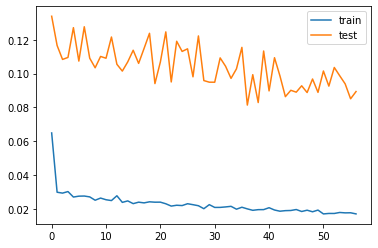

(41, 7)
(41, 7)
(41, 7)
score_train: [122.040] 118.9, 123.9, 130.9, 130.3, 120.8, 119.0, 109.0
(8, 1, 5)
score_test: [292.008] 311.4, 299.2, 14.5, 317.1, 420.9, 231.5, 280.9

RMSE test:  292.00784944308083 

9  	10    	262.603	5.68434e-14	262.603	262.603

Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.1346
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0298 - val_loss: 0.1146
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.1197
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.1293
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1182
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1201
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0267 - val_loss: 0.12

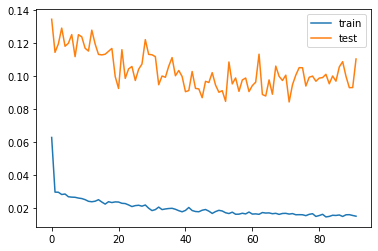

(41, 7)
(41, 7)
(41, 7)
score_train: [114.566] 108.4, 110.8, 125.2, 122.7, 110.9, 116.7, 105.9
(8, 1, 5)
score_test: [324.820] 324.2, 341.6, 69.1, 414.4, 430.5, 234.9, 316.0

RMSE test:  324.8195679421736 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0686 - val_loss: 0.1525
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1170
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1073
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1268
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1214
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0279 - val_loss: 0.1049
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1181
Epoch 8/1000
41/41 [=========================

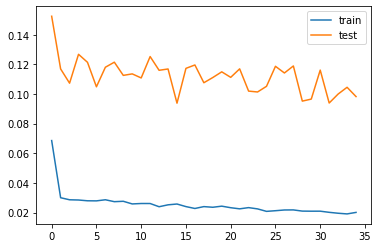

(41, 7)
(41, 7)
(41, 7)
score_train: [131.023] 127.4, 132.3, 138.0, 136.1, 128.4, 129.0, 125.5
(8, 1, 5)
score_test: [306.287] 323.1, 317.8, 40.2, 325.4, 450.6, 257.5, 272.8

RMSE test:  306.2865078984062 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0598 - val_loss: 0.1293
Epoch 2/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.1307
Epoch 3/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.1241
Epoch 4/1000
41/41 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.1273
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1213
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1165
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.1222
Epoch 8/1000
41/41 [=========================

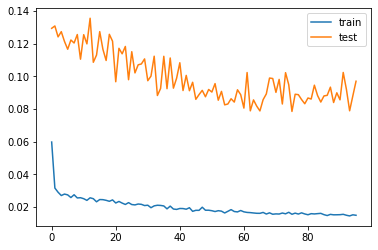

(41, 7)
(41, 7)
(41, 7)
score_train: [114.309] 110.0, 111.4, 124.0, 121.7, 106.8, 117.5, 107.3
(8, 1, 5)
score_test: [304.233] 298.2, 324.4, 48.2, 369.0, 408.7, 227.6, 310.4

RMSE test:  304.23332864083767 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.1070
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.1129
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1171
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.1188
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0280 - val_loss: 0.1257
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0271 - val_loss: 0.1187
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1150
Epoch 8/1000
41/41 [========================

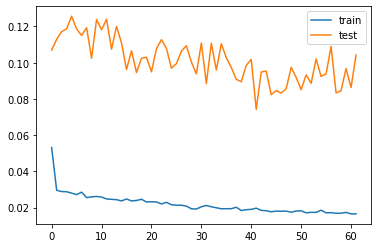

(41, 7)
(41, 7)
(41, 7)
score_train: [121.222] 113.1, 121.8, 130.0, 128.8, 120.8, 120.6, 112.4
(8, 1, 5)
score_test: [315.416] 303.2, 297.4, 32.9, 382.3, 448.0, 232.2, 337.9

RMSE test:  315.41645115170866 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0695 - val_loss: 0.1310
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0309 - val_loss: 0.1197
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1132
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1279
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0286 - val_loss: 0.1214
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1090
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.1190
Epoch 8/1000
41/41 [========================

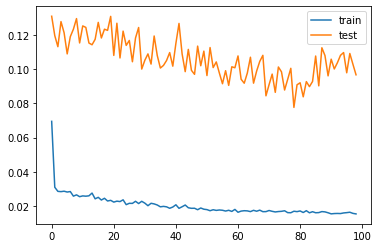

(41, 7)
(41, 7)
(41, 7)
score_train: [115.842] 111.7, 116.6, 124.3, 123.1, 111.4, 115.7, 107.1
(8, 1, 5)
score_test: [303.859] 307.6, 329.8, 52.2, 365.8, 407.1, 219.7, 303.9

RMSE test:  303.8590385706869 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.1422
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1121
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0310 - val_loss: 0.1287
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1189
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1202
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1185
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.1206
Epoch 8/1000
41/41 [=========================

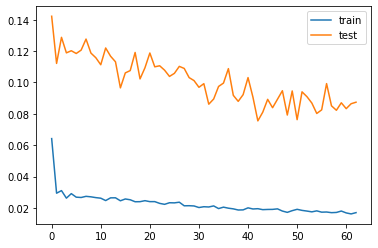

(41, 7)
(41, 7)
(41, 7)
score_train: [120.926] 116.5, 120.5, 131.0, 129.6, 118.9, 119.3, 109.4
(8, 1, 5)
score_test: [288.820] 305.0, 265.9, 13.4, 347.2, 412.7, 209.7, 291.8

RMSE test:  288.8197726770649 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.1168
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0277 - val_loss: 0.1190
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0301 - val_loss: 0.1257
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0288 - val_loss: 0.1148
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.1215
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.1219
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1257
Epoch 8/1000
41/41 [=========================

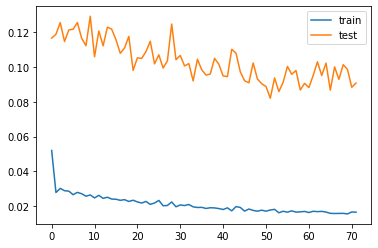

(41, 7)
(41, 7)
(41, 7)
score_train: [117.311] 112.8, 119.5, 125.5, 124.6, 115.9, 115.7, 106.0
(8, 1, 5)
score_test: [294.479] 298.7, 296.3, 26.9, 338.0, 424.7, 214.0, 298.1

RMSE test:  294.4793452569433 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.1304
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1166
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.1109
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0268 - val_loss: 0.1072
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0270 - val_loss: 0.1181
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0275 - val_loss: 0.1115
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0262 - val_loss: 0.1370
Epoch 8/1000
41/41 [=========================

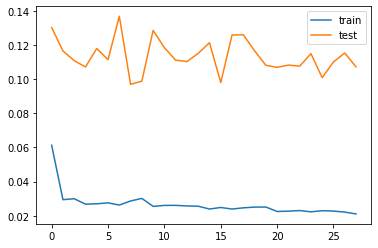

(41, 7)
(41, 7)
(41, 7)
score_train: [136.243] 133.1, 141.1, 140.6, 137.6, 132.8, 133.5, 134.8
(8, 1, 5)
score_test: [320.013] 330.4, 313.5, 36.9, 312.9, 495.8, 281.9, 291.3

RMSE test:  320.0128658056834 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.0752 - val_loss: 0.1596
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.1089
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0290 - val_loss: 0.1148
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1184
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0291 - val_loss: 0.1180
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1162
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.1123
Epoch 8/1000
41/41 [=========================

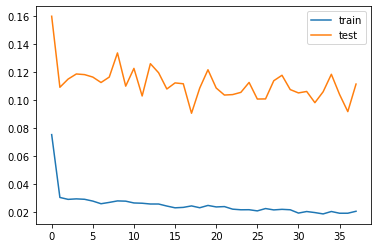

(41, 7)
(41, 7)
(41, 7)
score_train: [130.759] 127.0, 132.6, 138.2, 137.6, 128.1, 127.8, 123.2
(8, 1, 5)
score_test: [325.849] 339.6, 308.8, 16.4, 341.1, 480.8, 295.4, 312.3

RMSE test:  325.84949592217225 


Units CNN1:  255 ,Sequence size:  1
(41, 1, 5)
Epoch 1/1000
41/41 [==============================] - 0s 4ms/step - loss: 0.0677 - val_loss: 0.1291
Epoch 2/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0307 - val_loss: 0.0969
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0300 - val_loss: 0.1189
Epoch 4/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0294 - val_loss: 0.1210
Epoch 5/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.1055
Epoch 6/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.1001
Epoch 7/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.0278 - val_loss: 0.1084
Epoch 8/1000
41/41 [========================

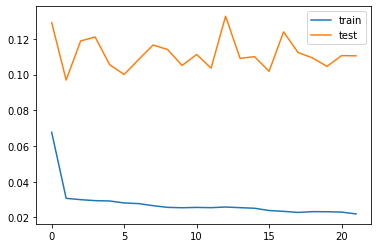

(41, 7)
(41, 7)
(41, 7)
score_train: [140.736] 137.7, 144.0, 142.8, 139.4, 136.6, 138.9, 145.4
(8, 1, 5)
score_test: [324.776] 340.4, 300.0, 45.7, 302.7, 507.8, 299.7, 301.7

RMSE test:  324.7764040216358 

10 	10    	262.603	5.68434e-14	262.603	262.603


In [76]:
population_size = 10
num_generations = 10
# 8 bits for ltsm1 , 8 for lstm 2 , 6 for sequence length , 21 for features selections
# 8 bits for cnn1 ,8 bits for cnn2 , 8 bits for lstm 2 ,8 bits for lstm 2 , 6 bits for sequence length , 21 for features selections
gene_length =14 #58

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.9)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.7)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)
population = toolbox.population(n = population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
#param cxpb: The probability of mating two individuals.
#param mutpb: The probability of mutating an individual.
population , logbook  = algorithms.eaSimple(population, toolbox,halloffame=hof, cxpb = 0.7, mutpb = 0.6,stats=stats, ngen = num_generations, verbose = True)

In [77]:
print('Best score :', best_score)

Best score : 262.60284288825255


In [78]:
model=model_name
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 1, 255)            2805      
_________________________________________________________________
flatten_22 (Flatten)         (None, 255)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 255)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 1792      
Total params: 4,597
Trainable params: 4,597
Non-trainable params: 0
_________________________________________________________________


In [79]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# make a prediction
yhat = model.predict(X_test[[0,7]])
yhat.shape 

(2, 7)

In [80]:
yhat = yhat.reshape(-1, yhat.shape[-1])

In [81]:
#yhat

In [82]:
# invert scaling for forecast
y_test_pred = scaler2.inverse_transform(yhat)
#print(inv_yhat)
# invert scaling for actual
Y_test_true =Y_test[[0,7]]
Y_test_true = Y_test_true.reshape(-1, Y_test_true.shape[-1])
y_test_true= scaler2.inverse_transform(Y_test_true)
#print(inv_y)

In [83]:
days

DatetimeIndex(['2020-08-02', '2020-08-03', '2020-08-04', '2020-08-05',
               '2020-08-06', '2020-08-07', '2020-08-08', '2020-08-09',
               '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [84]:
test_res=pd.DataFrame()
test_res['Prediction']=y_test_pred.flatten()[0:14]
test_res['real']=y_test_true.flatten()[0:14]
test_res.set_index(days,inplace=True)

In [85]:
test_res

,Prediction,real
timestamp,,
2020-08-02,680.800537,693.000000
2020-08-03,619.630188,522.000000
2020-08-04,688.550049,659.000000
2020-08-05,663.784851,1021.000061
2020-08-06,1145.723755,1283.000000
2020-08-07,975.869751,1144.000000
2020-08-08,711.485168,1017.999939
2020-08-09,944.670654,1345.000000
2020-08-10,855.013794,1230.000000


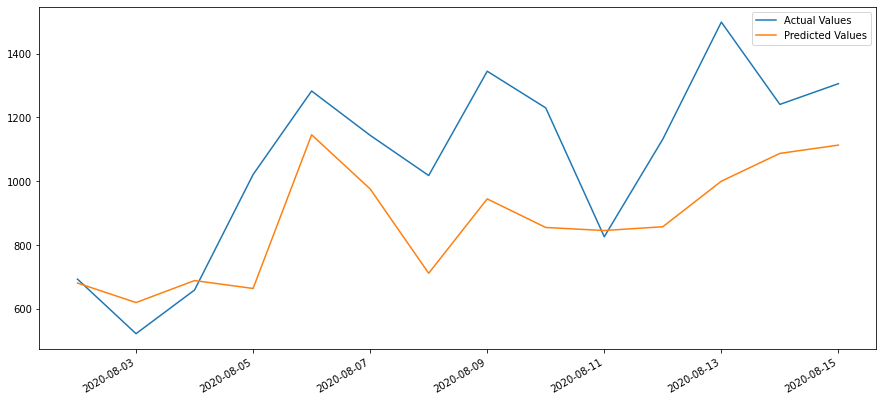

In [86]:

import pandas as pd
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()




In [87]:
import numpy as np 
from sklearn import metrics
print('Test Metrics')
print('MSE:', round(metrics.mean_squared_error(test_res['real'], test_res['Prediction']), 2))
print('RMSE:',round( np.sqrt(metrics.mean_squared_error(test_res['real'], test_res['Prediction'])), 2))
print('MAE:', round(metrics.mean_absolute_error(test_res['real'], test_res['Prediction']), 2))
print('R Squared:', round( metrics.r2_score(test_res['real'], test_res['Prediction']), 2))
print('Max Error:',round(  metrics.max_error(test_res['real'], test_res['Prediction']), 2))


Test Metrics
MSE: 68960.26
RMSE: 262.6
MAE: 215.94
R Squared: 0.12
Max Error: 498.78


In [88]:
# make a prediction
y_train_pred = model.predict(X_train)
y_train_pred .shape

(41, 7)

In [89]:
y_train_pred = y_train_pred.reshape(y_train_pred.shape[0], y_train_pred.shape[1])
y_train_pred.shape

(41, 7)

In [90]:

# invert scaling for forecast

y_train_pred = scaler2.inverse_transform(y_train_pred)
Y_train_true = Y_train.reshape((len(Y_train), n_out))

y_train_real = scaler2.inverse_transform(Y_train_true )

In [91]:

# Flatten for final errors
Y_train_pred_bis = y_train_pred.flatten()
Y_train_real_bis = y_train_real.flatten()

In [92]:
y_train_pred[0]

array([697.6489 , 722.38086, 761.1349 , 786.44183, 792.5827 , 777.20135,
       778.4679 ], dtype=float32)

In [93]:
#For plot 
#filter_indices = [0,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105]
filter_indices = [0,7,14,21,28]
y_train_pred = y_train_pred [filter_indices ]

In [94]:
# Part of train dataset
y_train_real= y_train_real[filter_indices]
Y_train_pred = y_train_pred.flatten()
Y_train_real = y_train_real.flatten()

In [95]:
mask = (df['date'] >= start_date) & (df['date'] <= end_date) &  (df['location'].isin(['Morocco']))
date_train = df.loc[mask].date.sort_index(axis = 0) 
X_train.shape

(41, 1, 5)

In [96]:
date_train.head(7)

23033   2020-06-15
23034   2020-06-16
23035   2020-06-17
23036   2020-06-18
23037   2020-06-19
23038   2020-06-20
23039   2020-06-21
Name: date, dtype: datetime64[ns]

In [97]:
taille_x = date_train.shape[0] - nb_seq
taille_x 

47

In [98]:
date_train = date_train.values.flatten()

In [99]:
prediction_train = pd.DataFrame(columns=['date_to_prediction','true_value','predict'])

In [100]:
Y_train_pred.shape

(35,)

In [101]:
Y_train_real.shape

(35,)

In [102]:
date_train.shape

(48,)

In [103]:
date_train[nb_seq:].shape

(47,)

In [104]:
suite_size = Y_train_real.shape[0]- date_train[nb_seq:].shape[0]
suite_size 

-12

In [105]:
Y_train_real[:-suite_size].shape

(12,)

In [106]:
date_train[nb_seq:].shape

(47,)

In [107]:
Y_train_pred[:-suite_size].shape

(12,)

In [108]:
Y_train_real[:-suite_size].shape

(12,)

In [109]:
date_trainX = date_train[nb_seq:]

In [110]:
date_trainX[0:Y_train_pred.shape[0]].shape

(35,)

In [111]:
prediction_train['date_to_prediction'] = date_trainX[0:Y_train_pred.shape[0]]
prediction_train['predict'] = Y_train_pred
prediction_train['true_value'] = Y_train_real


In [112]:
prediction_train['date_to_prediction'] = pd.to_datetime(prediction_train['date_to_prediction'], infer_datetime_format=True)

In [113]:
prediction_train.set_index('date_to_prediction',inplace=True)

In [114]:
prediction_train.head(20)

,true_value,predict
date_to_prediction,,
2020-06-16,617.586121,697.648926
2020-06-17,598.285034,722.380859
2020-06-18,591.851379,761.134888
2020-06-19,592.770508,786.441833
2020-06-20,1017.393250,792.582703
2020-06-21,694.790222,777.201355
2020-06-22,683.761047,778.467896
2020-06-23,701.223877,741.517822
2020-06-24,606.556946,787.290161


In [115]:
prediction_train.tail(10)

,true_value,predict
date_to_prediction,,
2020-07-11,870.337708,775.138245
2020-07-12,718.686768,772.107971
2020-07-13,708.576721,735.104614
2020-07-14,697.547546,660.182373
2020-07-15,669.974609,726.932739
2020-07-16,673.651062,754.804382
2020-07-17,670.893738,763.116455
2020-07-18,799.567261,790.550049
2020-07-19,787.619019,794.137451


"\nfig, ax = plt.subplots(figsize=(15,7))\nplt.plot(test_res.index, test_res['real'],  label='Actual Values')\nplt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')\n# If you don't like the break in the graph, change 90 to 89 in the above line\nplt.gcf().autofmt_xdate()\nplt.legend()\nplt.show()\n"

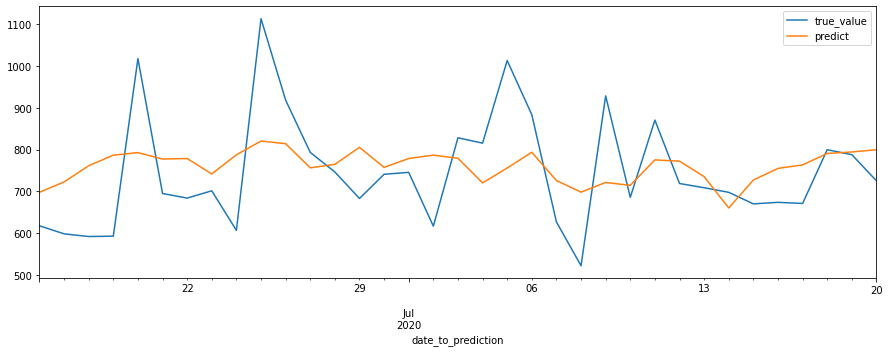

In [116]:
# Prédiction du train vs la réalité 
prediction_train.plot(figsize=(15,5))
'''
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(test_res.index, test_res['real'],  label='Actual Values')
plt.plot(test_res.index, test_res['Prediction'], label='Predicted Values')
# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()
'''

In [117]:
print('Trains Metrics')
loss = tf.keras.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis )
print('MSE',"{:.2f}".format(loss))
rmse = tf.sqrt(tf.losses.mean_squared_error(Y_train_real_bis, Y_train_pred_bis ))
print('RMSE',"{:.2f}".format(rmse))
loss2 = tf.keras.losses.MAE(Y_train_real_bis, Y_train_pred_bis )
print('MAE',"{:.2f}".format(loss2))
r2 =r2_score(Y_train_real_bis, Y_train_pred_bis )
print('R2',"{:.2f}".format(r2))
maxerror=max_error(Y_train_real_bis, Y_train_pred_bis )
print('maxError',"{:.2f}".format(maxerror))

Trains Metrics
MSE 13771.50
RMSE 117.35
MAE 91.95
R2 0.59
maxError 341.50
